# Numerical Experiments - Paper

In this notebook, we perform numerical experiments with random synthethically created data to compare the solution space of common sparse encoders to the multi-penalty framework and its solution space. By solution space comparison, we mean that we do not care about support selection or stopping criteria in this experiments. An algorithm is already considered as being successful if the correct support is anywhere among all supports that have been calculated while running the algorithm. 

The comparison will be between the multi-penalty framework and the following algorithms:
+ least absolute shrinkage and selection operator (LASSO) [1].
+ LASSO + iterative hard thresholding (IHT) [2].
+ preconditioned Lasso (pLASSO) [3].
+ orthogonal matching pursuit (OMP) [4].

Note that, of the tested algorithms, most do only have a single solution to a specific support size. For these, the experiments are equal to experiments where we simply give the support size as an oracle parameter/stopping criterion to the algorithm (OMP, LAR). For LASSO and pLASSO however, it can happen that multiple supports are found to a single support size. In this case, we look whether or not the generating support is among them, and if so, consider an experiment successfull.

In [42]:
methods = ['lasso', 'plasso', 'omp', 'l1iht']

The code that is used to perform these experiments is contained in the repositories https://github.com/soply/mpgraph for the multi-penalty framework and in https://github.com/soply/sparse_encoder_testsuite for other methods. The code is well-documented, therefore we refer for further information to these repositories.e to run these experiments will be made public after publication.

#### Creating the data for the experiments
The data is created by using the methods provided in the ```problem_factory``` subfolder of the ```mpgraph``` repository or the ```sparse_encoder_testsuite``` repository. Essentially, we use Gaussian random matrices $A \in \mathbb{R}^{m \times n}$, a random signal $u \in \mathbb{R}^n$ and random signal noise $v \in \mathbb{R}^n$. This yields $y = A(u+v)$. The characteristics of $u, v$ are specified in the problem dictionaries. Details on what the entries in this dictionaries mean can be found in the source code. Moreover, in some cases we add additional measurement noise on y.

## 0. Import the code to multi-penalty framework and sparse encoders

In [43]:
import sys
import numpy as np
relative_path_to_mp_source = '../tiling_graph/' # My relative path to the multi-penalty source code
relative_path_to_sparse_encoder_source = '../sparse_encoders_unmixing/' # My relative path to the sparse_encoders source code
sys.path.append(relative_path_to_mp_source)
sys.path.append(relative_path_to_sparse_encoder_source)
from mpgraph.run_multiple_batches import main as main_mp # Run method multi-penalty
from mpgraph.mpgraph.plot_tools.parameter_analysis import success_vs_beta_disc
from sparse_encoders.run_multiple_batches import main as main_se # Run method rest
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_sparsity_level # Plotting results
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_signal_noise # Plotting results
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_signal_gap
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import symmdiff_vs_xaxis
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import success_vs_xaxis
from sparse_encoders.sparse_encoder_test_suite.plot_tools.multiple_methods_multiple_batches import time_vs_xaxis

# Defining the tiling creation options for multi-penalty LARS and multi-penalty LASSO methods
tiling_options_LASSO = {
    'verbose': 0,
    'mode': 'LASSO',
    'print_summary': False
}

# Fixed matrix size and run characteristics, varying support size

## 1. Case Gaussian $600 \times 2500$

In [44]:
# Specifying a problem
identifier1 = 'new_gauss_hd1_so' # For saving the files to some folder
random_seeds = [2641511602, 3040771731, 4037290260, 2868473942, 2343931798,
        478240178, 1073283435, 1436433477,  348580479, 3951235869,
         15011253, 3959489981, 1546964579, 2099488633, 1645792447,
       3802518163]
problem1 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 600, # = m
    'n_features': 2500, # = n
    'sparsity_level': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40], # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v.
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.02, # No measurement noise
    'random_seed': random_seeds,
    'verbosity' : False,
    'sampling_matrix_type' : 'gaussian',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier1, '-m', method], problem1)

In [ ]:
%%capture
problem1_mpsr_lasso = dict(problem1)
# Update with multi-penalty framework properties
problem1_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier1], problem1_mpsr_lasso)

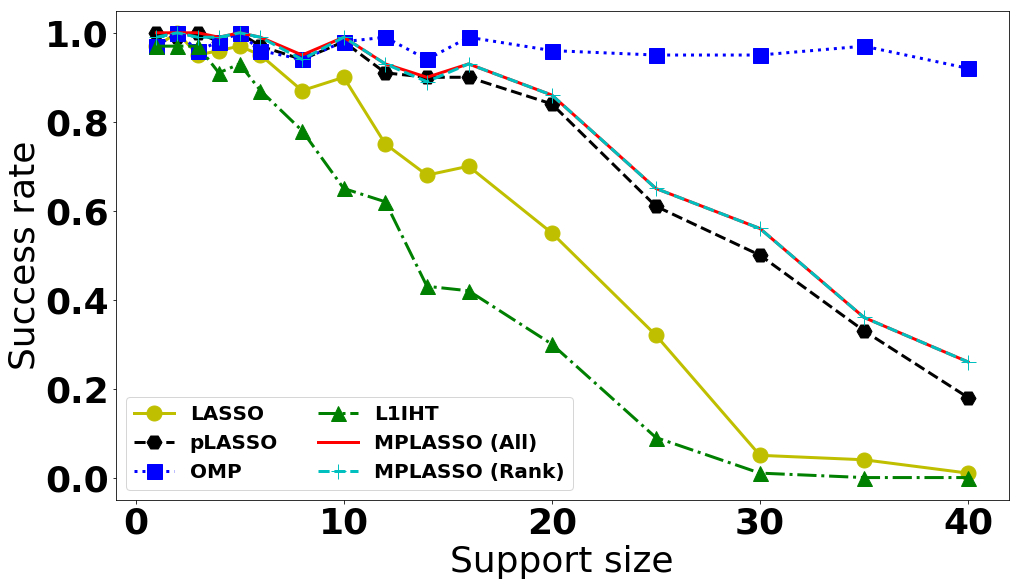

In [130]:
success_vs_sparsity_level('results_multiple_batches', identifier1, methods + ['mp_LASSO', 'mp_LASSO'], 
                          alternative_keys = ['success', 'success', 'success','success','tiling_contains_real',
                                             'highest_ranked_is_real'],
                          legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                          xlabel='Support size', ylabel='Success rate', leg_loc = 'lower left', title = '',
                          save_as = 'img/' + identifier1 + 'success.png')

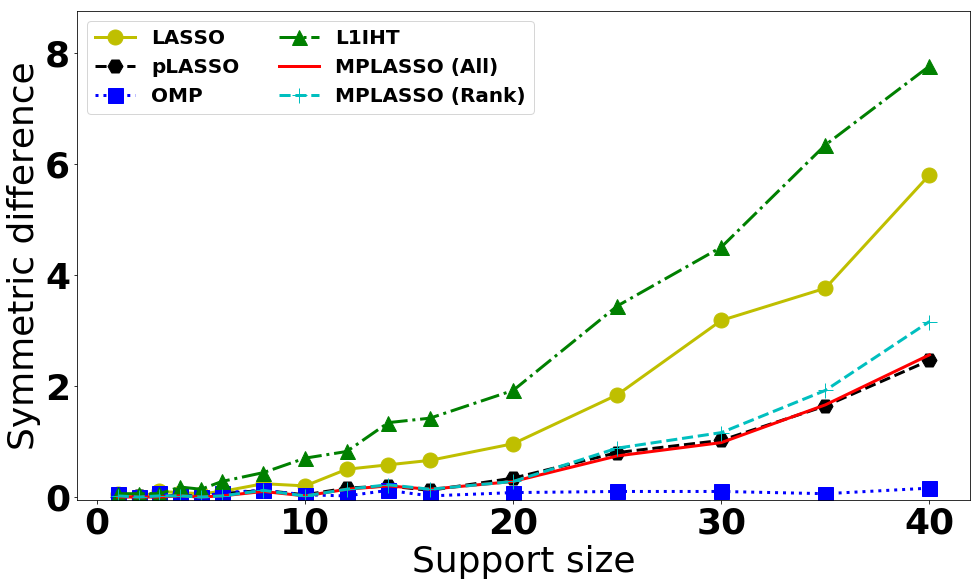

In [76]:
symmdiff_vs_xaxis('results_multiple_batches', identifier1, methods + ['mp_LASSO', 'mp_LASSO'], 'sparsity_level',
                  r'Support size',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left', title = '',
                  save_as = 'img/' + identifier1 + 'symm_diff.png')

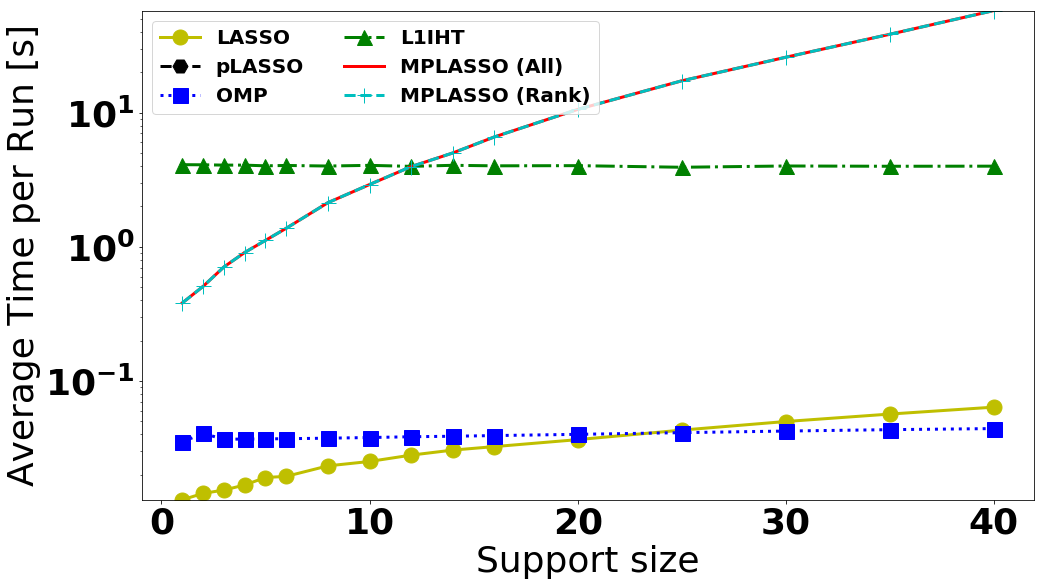

In [77]:
time_vs_xaxis('results_multiple_batches', identifier1, methods + ['mp_LASSO', 'mp_LASSO'], 'sparsity_level',
              r'Support size', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'upper left', title = '',
              save_as = 'img/' + identifier1 + 'time.png')

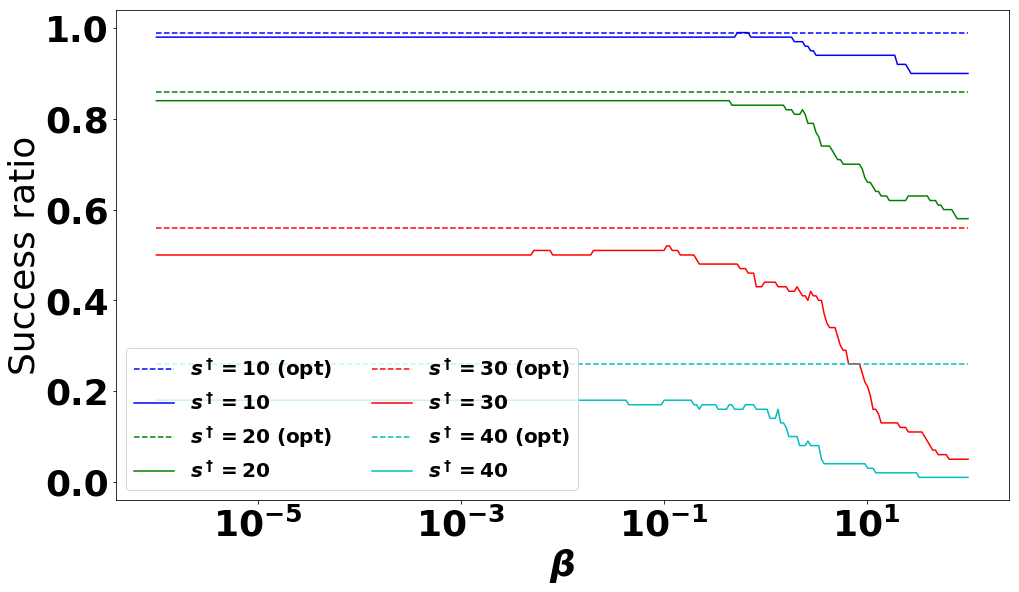

In [78]:
success_vs_beta_disc('results_multiple_batches', identifier1, 'mp_LASSO', 'sparsity_level',  [10, 20, 30, 40],
                    title = '', leg_loc = 'lower left', 
                    legend_entries = [r'$s^\dagger = 10$ (opt)', r'$s^\dagger = 10$',
                                     r'$s^\dagger = 20$ (opt)', r'$s^\dagger = 20$',
                                     r'$s^\dagger = 30$ (opt)', r'$s^\dagger = 30$',
                                     r'$s^\dagger = 40$ (opt)', r'$s^\dagger = 40$'],
                     ylabel = 'Success ratio',
                     save_as = 'img/' + identifier1 + 'beta.png')

## 2. Case Partial Random Circulant Matrix $900 \times 2500$

In [50]:
# Specifying a problem
identifier2 = 'new_prcm_hd1_so' # For saving the files to some folder
random_seeds = [3040771731, 4037290260, 2868473942, 2343931798,
        478240178, 1073283435, 1436433477,  348580479, 3951235869,
         15011253, 3959489981, 1546964579, 2099488633, 1645792447,
       3802518163, 158128457]
problem2 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 900, # = m
    'n_features': 2500, # = n
    'sparsity_level': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40], # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v.
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.02, # No measurement noise
    'random_seed': random_seeds,
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier2, '-m', method], problem2)

In [ ]:
%%capture
problem2_mpsr_lasso = dict(problem2)
# Update with multi-penalty framework properties
problem2_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier2], problem2_mpsr_lasso)

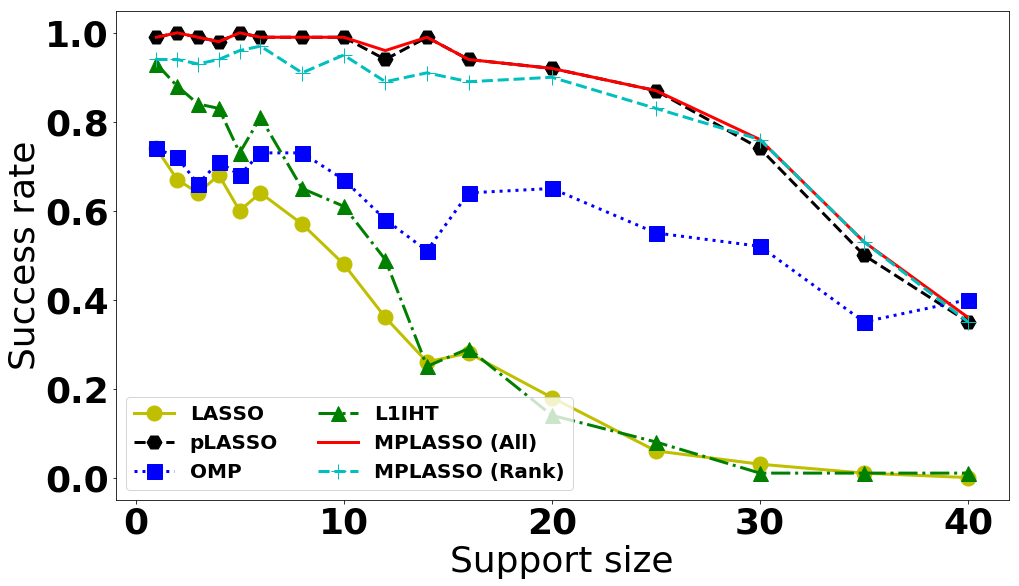

In [131]:
success_vs_sparsity_level('results_multiple_batches', identifier2, methods + ['mp_LASSO', 'mp_LASSO'], 
                          alternative_keys = ['success', 'success', 'success','success','tiling_contains_real',
                                             'highest_ranked_is_real'],
                          legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                          xlabel='Support size', ylabel = 'Success rate', leg_loc = 'lower left', title = '',
                          save_as = 'img/' + identifier2 + 'success.png')

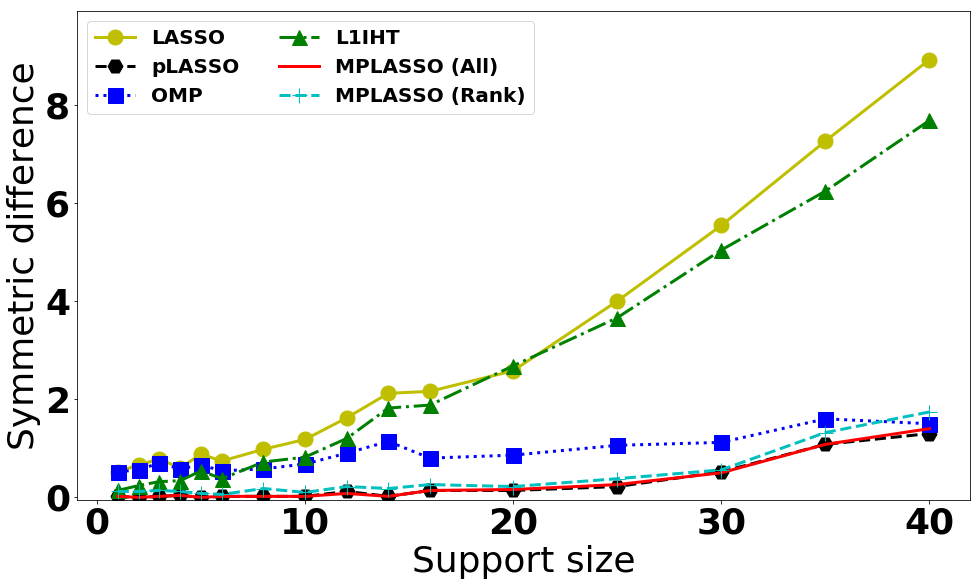

In [52]:
symmdiff_vs_xaxis('results_multiple_batches', identifier2, methods + ['mp_LASSO', 'mp_LASSO'], 'sparsity_level',
                  r'Support size',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left', title = '',
                  save_as = 'img/' + identifier2 + 'symm_diff.png')

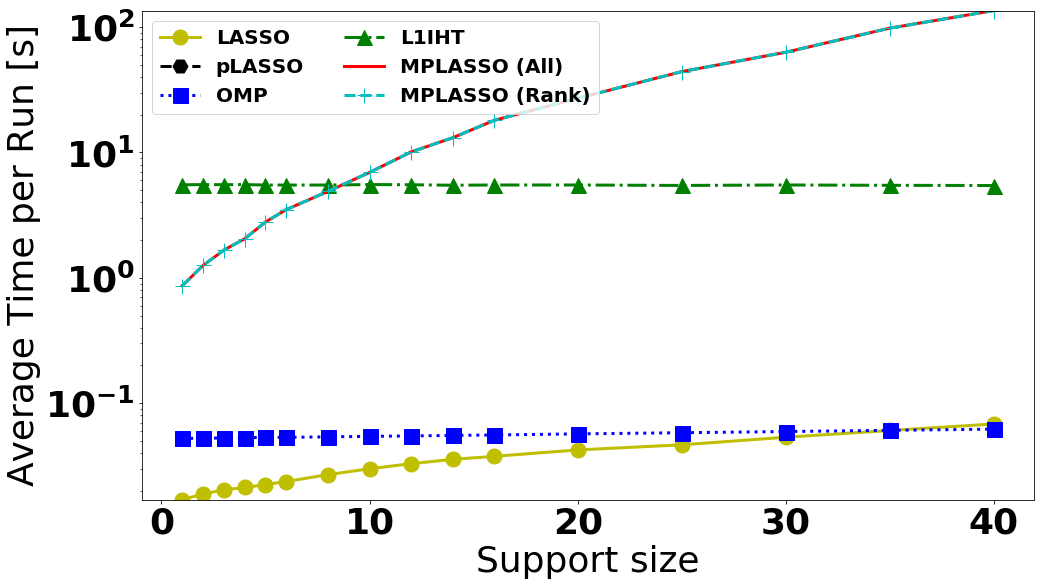

In [53]:
time_vs_xaxis('results_multiple_batches', identifier2, methods + ['mp_LASSO', 'mp_LASSO'], 'sparsity_level',
              r'Support size', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'upper left', title = '',
              save_as = 'img/' + identifier2 + 'time.png')

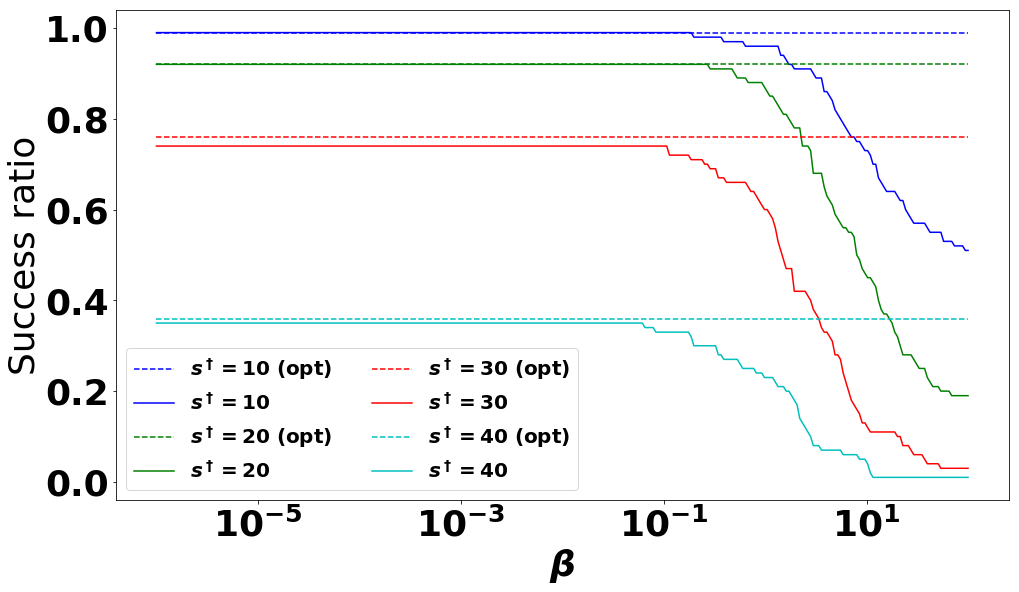

In [55]:
success_vs_beta_disc('results_multiple_batches', identifier2, 'mp_LASSO', 'sparsity_level',  [10, 20, 30, 40],
                    title = '', leg_loc = 'lower left', 
                    legend_entries = [r'$s^\dagger = 10$ (opt)', r'$s^\dagger = 10$',
                                     r'$s^\dagger = 20$ (opt)', r'$s^\dagger = 20$',
                                     r'$s^\dagger = 30$ (opt)', r'$s^\dagger = 30$',
                                     r'$s^\dagger = 40$ (opt)', r'$s^\dagger = 40$'],
                     ylabel = 'Success ratio', save_as = 'img/' + identifier2 + 'beta.png')

## 3. Case Gamma/Gaussian $900 \times 2500$

In [57]:
# Specifying a problem
identifier3 = 'new_gamma_gaussian_hd1_so' # For saving the files to some folder
random_seeds = [3031864117, 4258048881,  930256654,  466547429, 2013959566,
       2553295643, 1853730796, 1277323287, 1145649603, 2055818864,
       2290379874, 1416705293, 1353413957, 2617187475, 1126126763,
       1418794198]
problem3 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 900, # = m
    'n_features': 2500, # = n
    'sparsity_level': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40], # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v.
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.02, # No measurement noise
    'random_seed': random_seeds,
    'verbosity' : False,
    'sampling_matrix_type' : ('gamma_gaussian', 1.0, 1.0),
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier3, '-m', method], problem3)

In [ ]:
%%capture
problem3_mpsr_lasso = dict(problem3)
# Update with multi-penalty framework properties
problem3_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 25, 30, 35, 40]}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier3], problem3_mpsr_lasso)

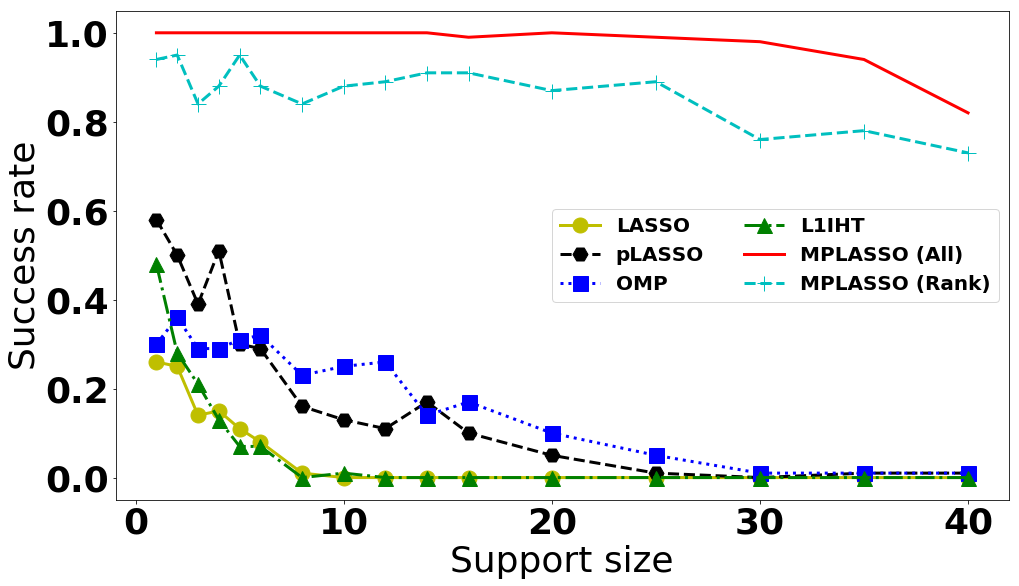

In [132]:
success_vs_sparsity_level('results_multiple_batches', identifier3, methods + ['mp_LASSO', 'mp_LASSO'], 
                          alternative_keys = ['success', 'success', 'success','success','tiling_contains_real',
                                             'highest_ranked_is_real'],
                          legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                          xlabel='Support size', leg_loc = 'center right', title = '',
                          ylabel = 'Success rate', save_as = 'img/' + identifier3 + 'success.png')

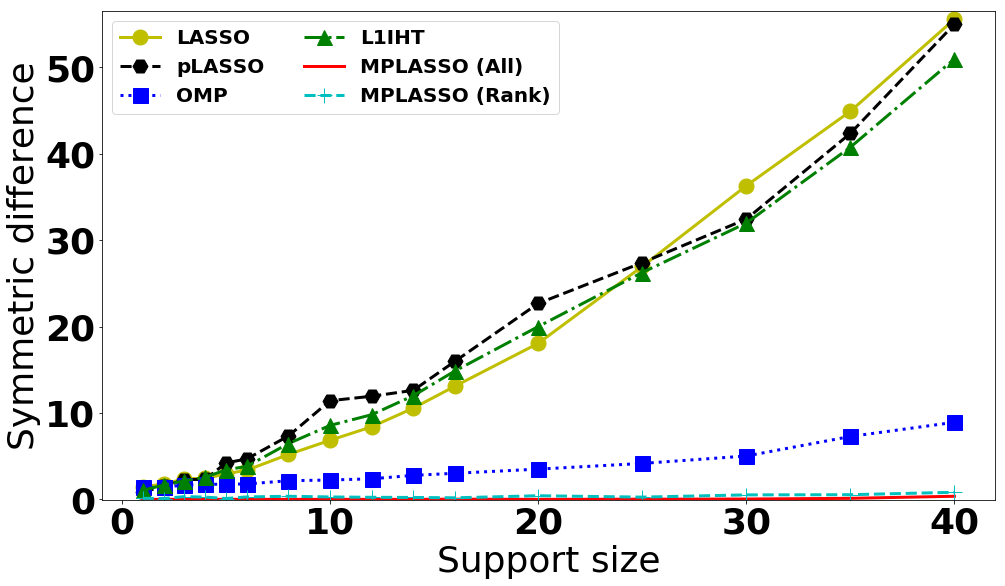

In [60]:
symmdiff_vs_xaxis('results_multiple_batches', identifier3, methods + ['mp_LASSO', 'mp_LASSO'], 'sparsity_level',
                  r'Support size',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left', title = '', save_as = 'img/' + identifier3 + 'symm_diff.png')

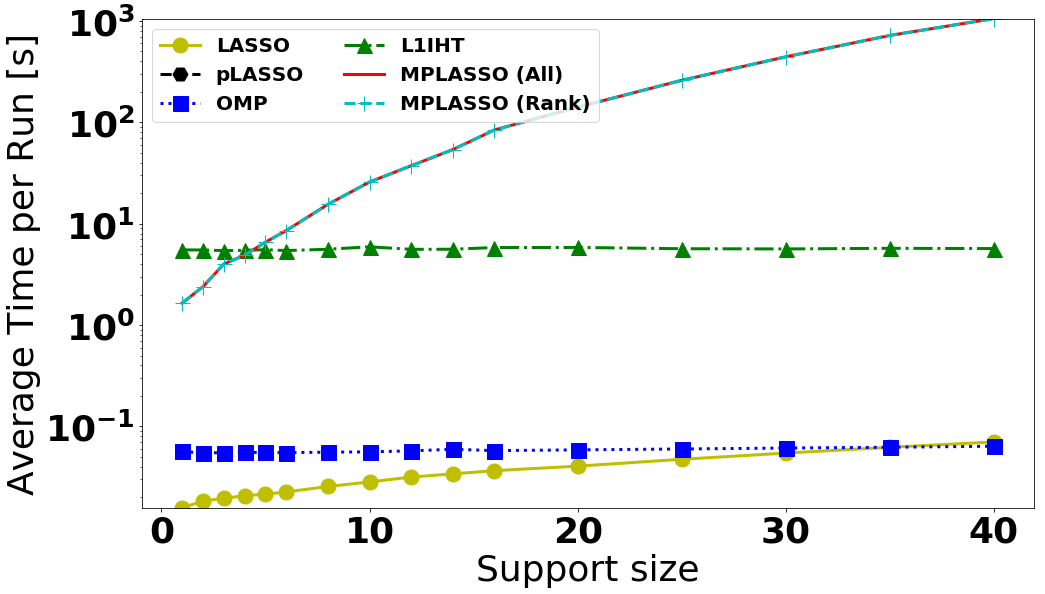

In [61]:
time_vs_xaxis('results_multiple_batches', identifier3, methods + ['mp_LASSO', 'mp_LASSO'], 'sparsity_level',
              r'Support size', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'upper left', title = '', save_as = 'img/' + identifier3 + 'time.png')

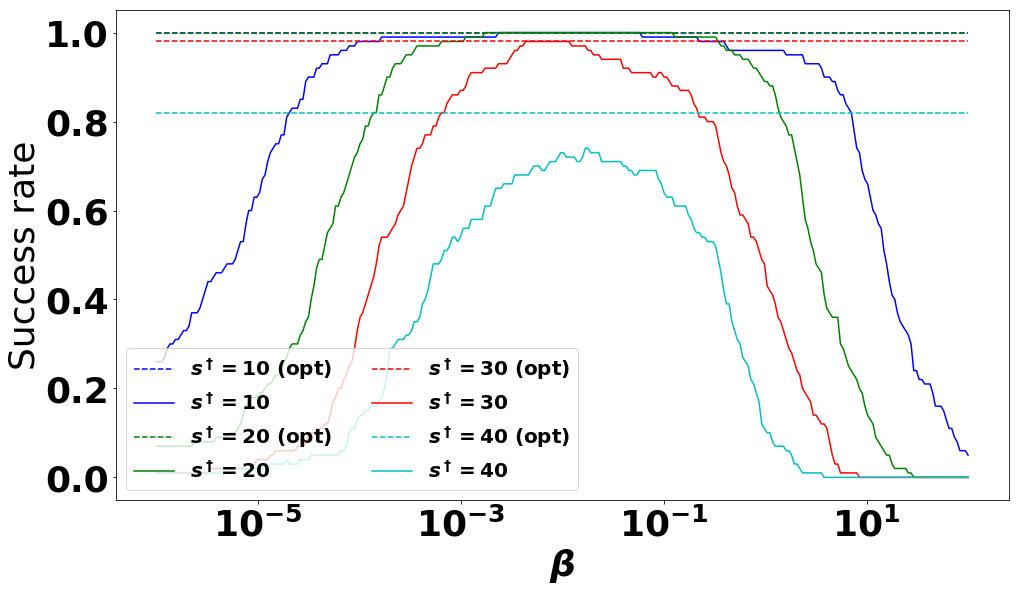

In [62]:
success_vs_beta_disc('results_multiple_batches', identifier3, 'mp_LASSO', 'sparsity_level',  [10, 20, 30, 40],
                    ylabel = 'Success rate',
                    title = '', leg_loc = 'lower left', 
                    legend_entries = [r'$s^\dagger = 10$ (opt)', r'$s^\dagger = 10$',
                                     r'$s^\dagger = 20$ (opt)', r'$s^\dagger = 20$',
                                     r'$s^\dagger = 30$ (opt)', r'$s^\dagger = 30$',
                                     r'$s^\dagger = 40$ (opt)', r'$s^\dagger = 40$'],
                    save_as = 'img/' + identifier3 + 'beta.png')

# Increasing features while holding support size and measurements constant

## 1.Case Gaussian Matrix

In [63]:
# Specifying a problem
identifier4 = 'new_gauss_incfeat1_so' # For saving the files to some folder
random_seeds = [4150305492, 2005039849, 3292574568, 4237914828, 1772774362,
       1926960685,  144503702,  370866252,  881811968,  102719404,
       2451094439]
problem4 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 250, # = m
    'n_features': [32,64,128,256,512,1024,2048,4096,8192,16384,32768], # = n
    'sparsity_level': 20, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v.
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.02, # No measurement noise
    'random_seed': random_seeds,
    'verbosity' : False,
    'sampling_matrix_type' : 'gaussian',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [6]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier4, '-m', method], problem4)

In [ ]:
%%capture
problem4_mpsr_lasso = dict(problem4)
# Update with multi-penalty framework properties
problem4_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 22}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier4], problem4_mpsr_lasso)

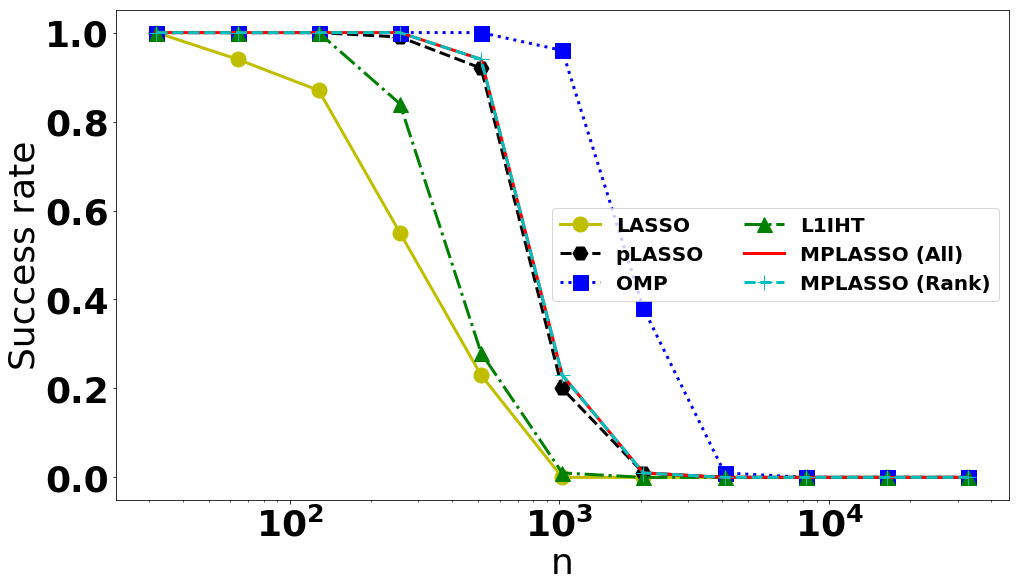

In [64]:
success_vs_xaxis('results_multiple_batches', identifier4, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
                  r'n',
                  alternative_keys = ['success', 'success', 'success','success','tiling_contains_real',
                                             'highest_ranked_is_real'],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  xscaling = 'log', ylabel = 'Success rate',
                  leg_loc = 'center right', title = '',
                  save_as = 'img/' + identifier4 + 'success.png')

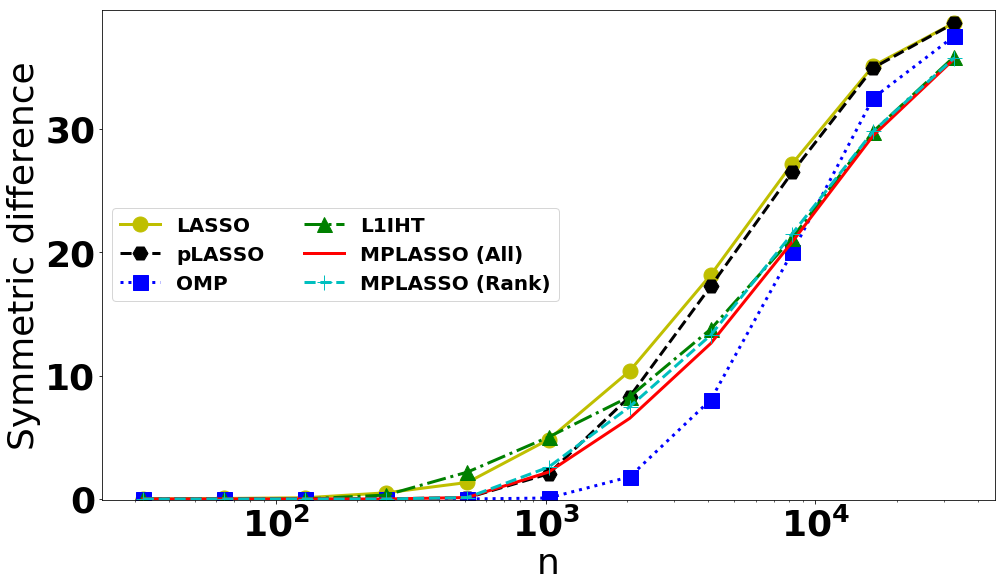

In [66]:
symmdiff_vs_xaxis('results_multiple_batches', identifier4, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
                  r'n',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  xscaling = 'log', save_as = 'img/' + identifier4 + 'symm_diff.png',
                  leg_loc = 'center left', title = '')

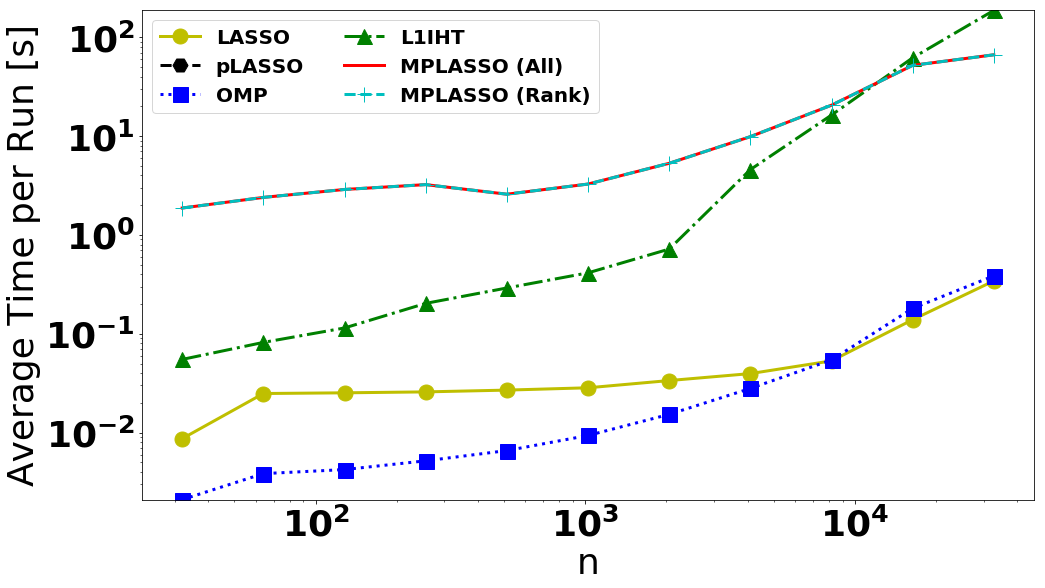

In [67]:
time_vs_xaxis('results_multiple_batches', identifier4, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
              r'n', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              xscaling = 'log', leg_loc = 'upper left', title = '', 
              save_as = 'img/' + identifier4 + 'time.png')

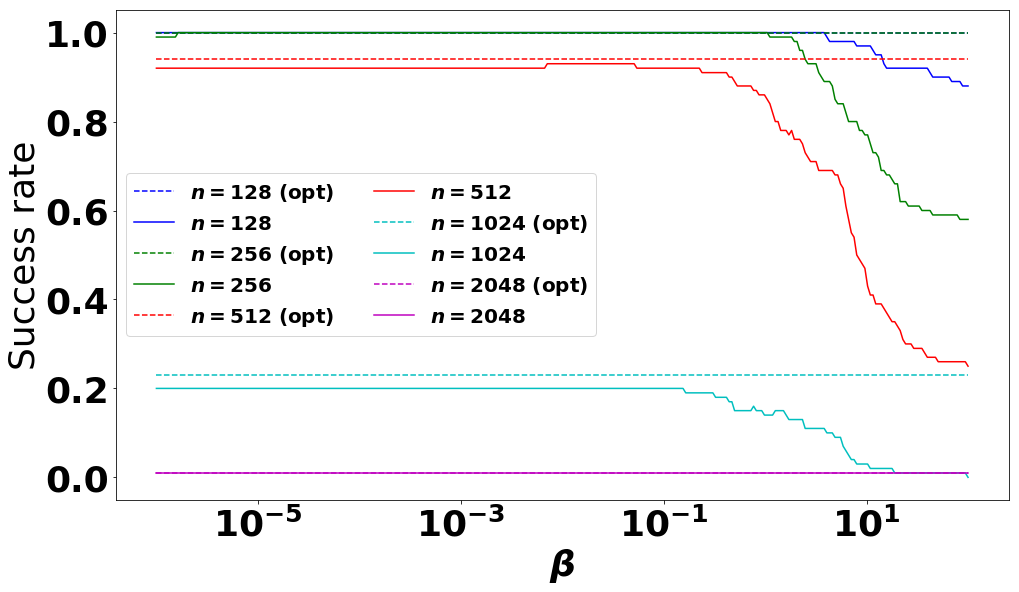

In [68]:
success_vs_beta_disc('results_multiple_batches', identifier4, 'mp_LASSO', 'n_features',  [128, 256, 512, 1024, 2048],
                    ylabel = 'Success rate',
                    title = '', leg_loc = 'center left', 
                    legend_entries = [r'$n = 128$ (opt)', r'$n = 128$',
                                     r'$n = 256$ (opt)', r'$n = 256$',
                                      r'$n = 512$ (opt)', r'$n = 512$',
                                     r'$n = 1024$ (opt)', r'$n = 1024$',
                                     r'$n = 2048$ (opt)', r'$n = 2048$'],
                    save_as = 'img/' + identifier4 + 'beta.png')

## 2. Case Partial Random Circulant Matrix

In [69]:
# Specifying a problem
identifier5 = 'new_prcm_incfeat1_so' # For saving the files to some folder
random_seeds = [3451528075, 3912321094, 3571203611, 2835921197, 1542806984,
        577214431, 3865410209, 3535591004, 1312536024, 1091284753,
       3706766505]
problem5 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 250, # = m
    'n_features': [32,64,128,256,512,1024,2048,4096,8192,16384,32768], # = n
    'sparsity_level': 20, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v.
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.02, # No measurement noise
    'random_seed': random_seeds,
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier5, '-m', method], problem5)

In [ ]:
%%capture
problem5_mpsr_lasso = dict(problem5)
# Update with multi-penalty framework properties
problem5_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 22}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier5], problem5_mpsr_lasso)

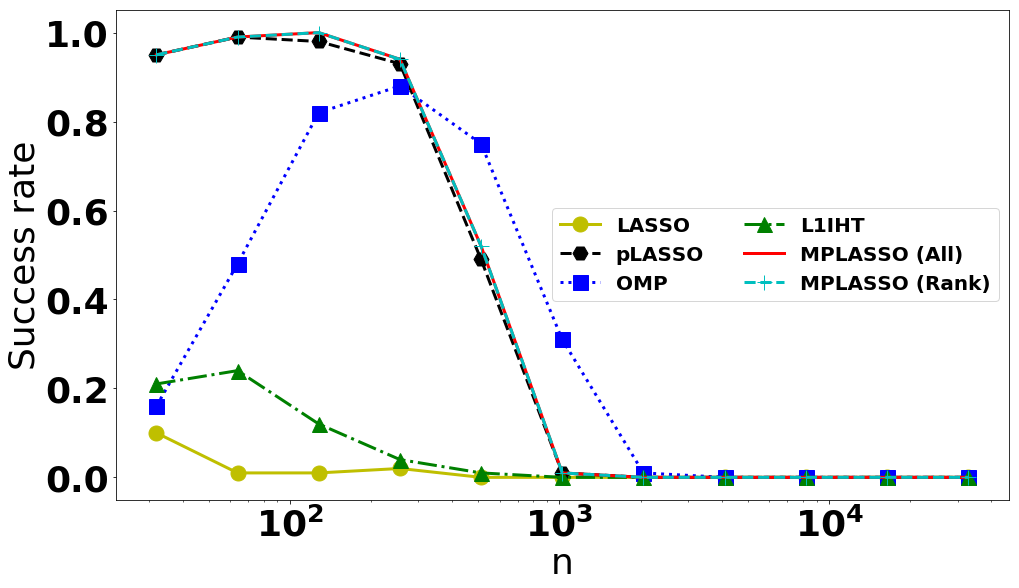

In [70]:
success_vs_xaxis('results_multiple_batches', identifier5, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
                  r'n',
                  alternative_keys = ['success', 'success', 'success','success','tiling_contains_real',
                                             'highest_ranked_is_real'],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  xscaling = 'log', ylabel = 'Success rate', leg_loc = 'center right', title = '',
                  save_as = 'img/' + identifier5 + 'success.png')

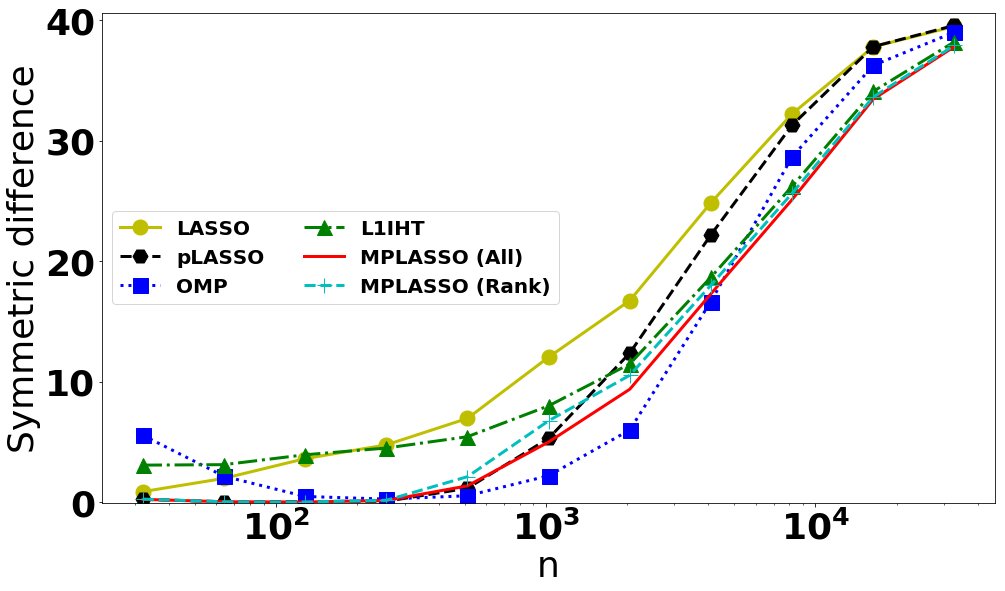

In [74]:
symmdiff_vs_xaxis('results_multiple_batches', identifier5, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
                  r'n',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  xscaling = 'log', leg_loc = 'center left', title = '',
                  save_as = 'img/' + identifier5 + 'symm_diff.png')

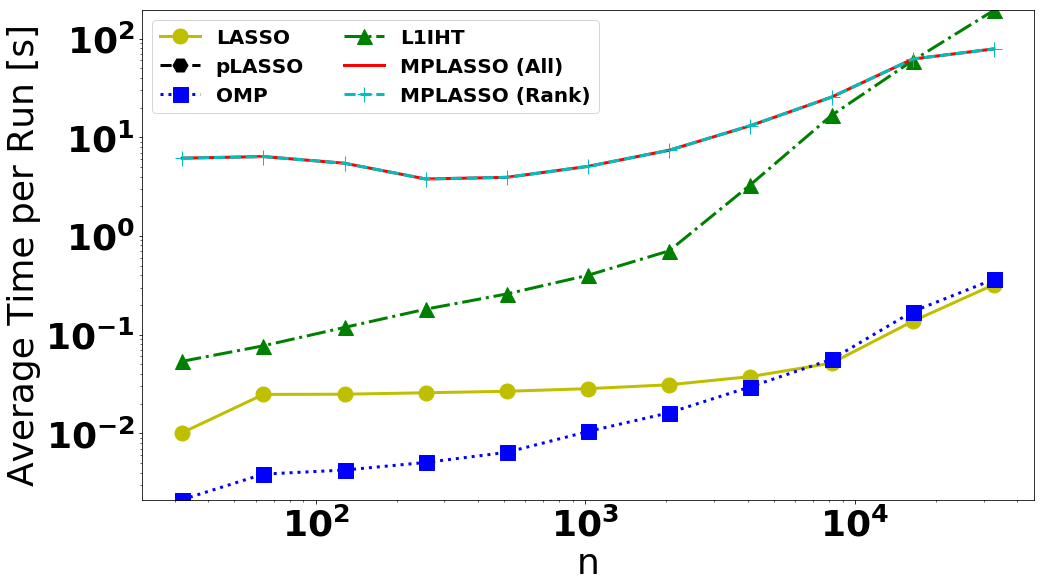

In [73]:
time_vs_xaxis('results_multiple_batches', identifier5, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
              r'n', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              xscaling = 'log', leg_loc = 'upper left', title = '',
              save_as = 'img/' + identifier5 + 'time.png')

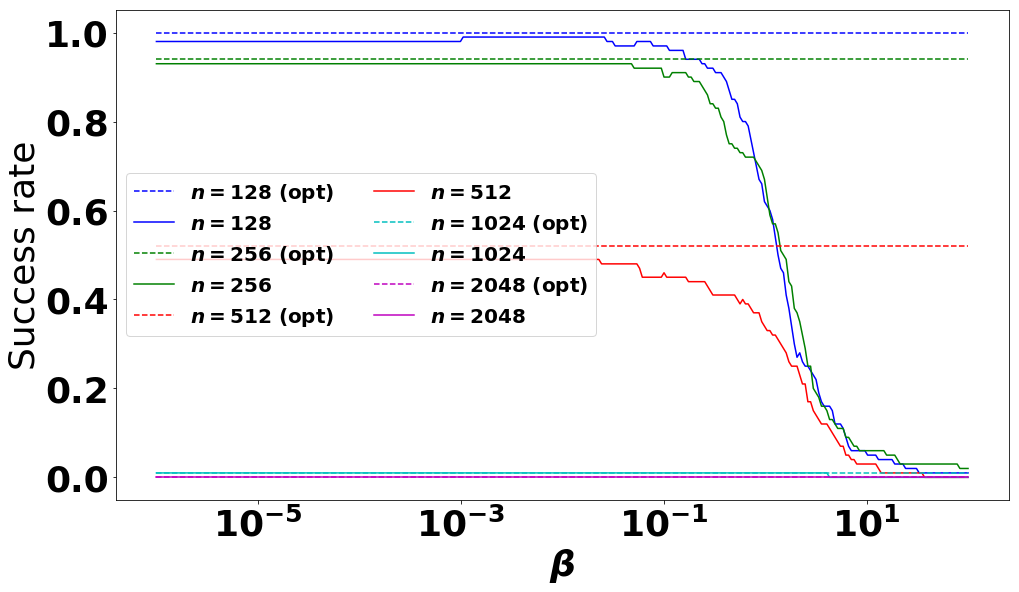

In [79]:
success_vs_beta_disc('results_multiple_batches', identifier5, 'mp_LASSO', 'n_features',  [128, 256, 512, 1024, 2048],
                    ylabel = 'Success rate',
                    title = '', leg_loc = 'center left', 
                    legend_entries = [r'$n = 128$ (opt)', r'$n = 128$',
                                     r'$n = 256$ (opt)', r'$n = 256$',
                                      r'$n = 512$ (opt)', r'$n = 512$',
                                     r'$n = 1024$ (opt)', r'$n = 1024$',
                                     r'$n = 2048$ (opt)', r'$n = 2048$'],
                    save_as = 'img/' + identifier5 + 'beta.png')

## 3. Case Gamma/Gaussian Matrix

In [80]:
# Specifying a problem
identifier6 = 'new_gamma_gaussian_incfeat1_so' # For saving the files to some folder
random_seeds = [2959391896,  650994105,  791442998, 2139609105, 1322551070,
       1751961413, 2004036970, 2469996790,  477000638,  394809271,
         41823546]
problem6 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 250, # = m
    'n_features': [32,64,128,256,512,1024,2048,4096,8192,16384,32768], # = n
    'sparsity_level': 20, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v.
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': 0.02, # No measurement noise
    'random_seed': random_seeds,
    'verbosity' : False,
    'sampling_matrix_type' : ('gamma_gaussian', 1.0, 1.0),
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier6, '-m', method], problem6)

In [ ]:
%%capture
problem6_mpsr_lasso = dict(problem6)
# Update with multi-penalty framework properties
problem6_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-13, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 22}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier6], problem6_mpsr_lasso)

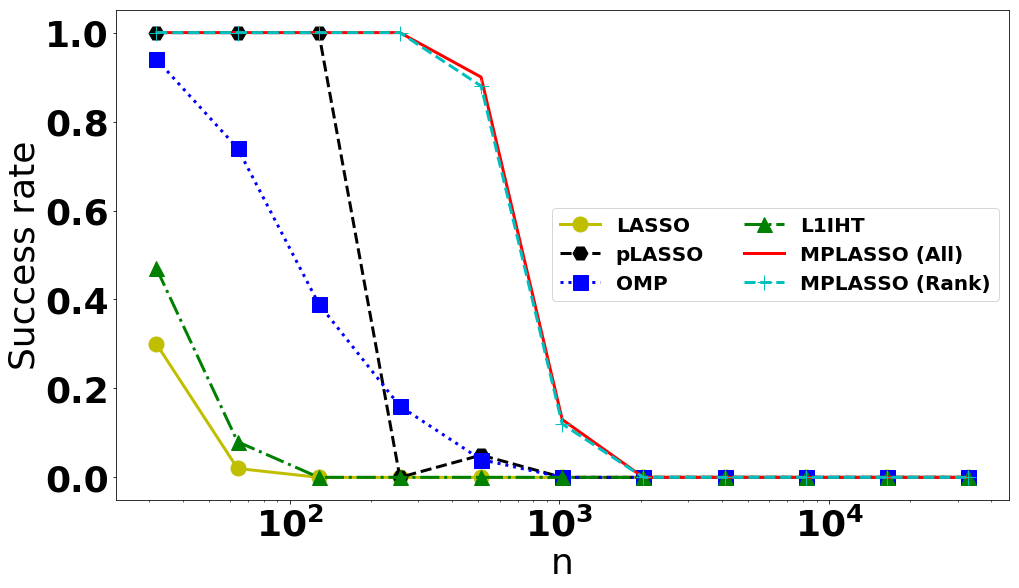

In [81]:
success_vs_xaxis('results_multiple_batches', identifier6, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
                  r'n',
                  alternative_keys = ['success', 'success', 'success','success','tiling_contains_real',
                                             'highest_ranked_is_real'],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  xscaling = 'log', ylabel = 'Success rate', leg_loc = 'center right', title = '',
                  save_as = 'img/' + identifier6 + 'success.png')

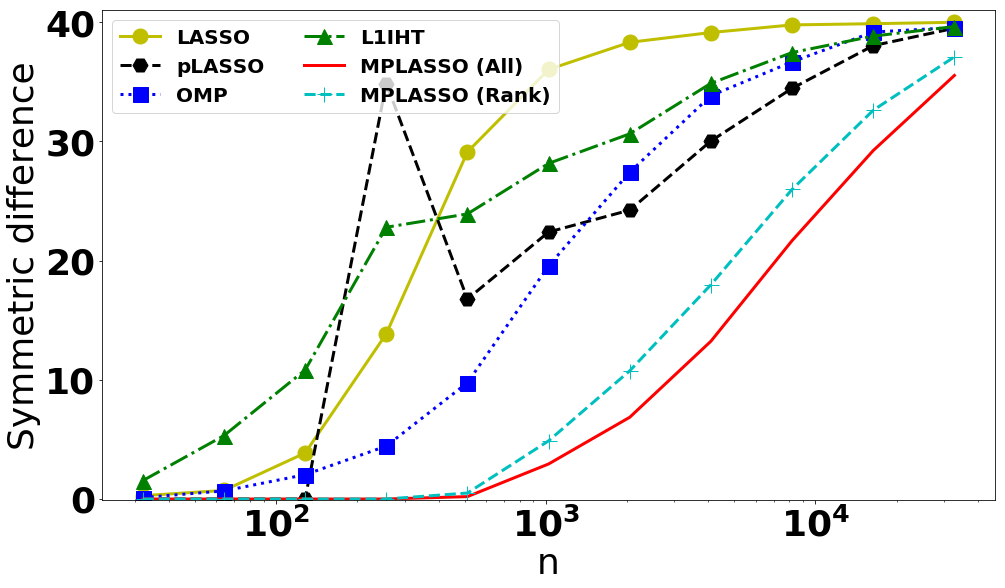

In [82]:
symmdiff_vs_xaxis('results_multiple_batches', identifier6, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
                  r'n',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  xscaling = 'log', leg_loc = 'upper left', title = '',
                  save_as = 'img/' + identifier6 + 'symm_diff.png')

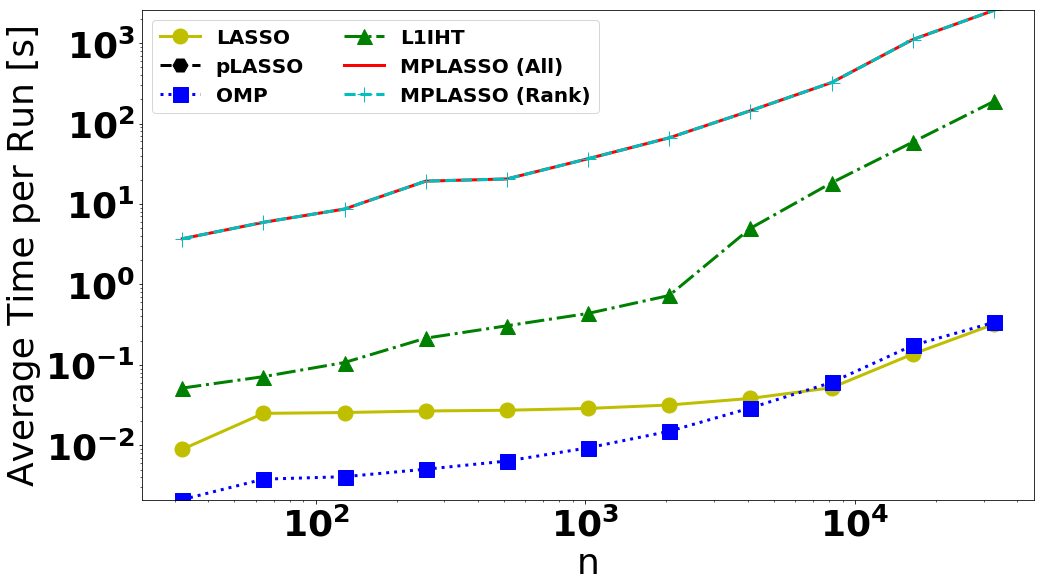

In [83]:
time_vs_xaxis('results_multiple_batches', identifier6, methods + ['mp_LASSO', 'mp_LASSO'], 'n_features',
              r'n', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              xscaling = 'log', leg_loc = 'upper left', title = '',
              save_as = 'img/' + identifier6 + 'time.png')

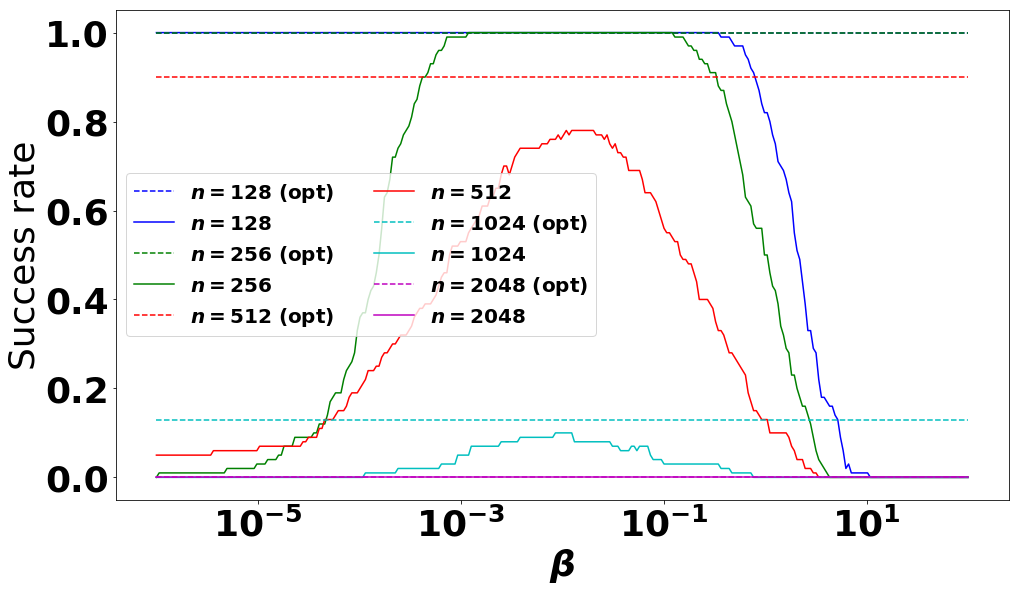

In [84]:
success_vs_beta_disc('results_multiple_batches', identifier6, 'mp_LASSO', 'n_features',  [128, 256, 512, 1024, 2048],
                    ylabel = 'Success rate',
                    title = '', leg_loc = 'center left', 
                    legend_entries = [r'$n = 128$ (opt)', r'$n = 128$',
                                     r'$n = 256$ (opt)', r'$n = 256$',
                                      r'$n = 512$ (opt)', r'$n = 512$',
                                     r'$n = 1024$ (opt)', r'$n = 1024$',
                                     r'$n = 2048$ (opt)', r'$n = 2048$'],
                    save_as = 'img/' + identifier6 + 'beta.png')

# Varying measurement noise $\delta = \frac{\Vert y \Vert_2}{\Vert \varepsilon \Vert_2}$

## 1.1. Case Gaussian Matrix $600 \times 2500$

In [89]:
# Specifying a problem
identifier7 = 'new_gaussian_measurement_noise_so' # For saving the files to some folder
#random_seeds = np.random.randint(1, 4294967295, size=(16))
random_seeds = [1300131961, 1514735035,  464034286, 2273585905,  464074931,
       1505704288, 3053733860,  198950948, 2304510769,  548190480]
problem7 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 600, # = m 
    'n_features': 2500, # = n
    'sparsity_level': 15, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1], # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'gaussian',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier7, '-m', method], problem7)

In [ ]:
%%capture
problem7_mpsr_lasso = dict(problem7)
# Update with multi-penalty framework properties
problem7_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 18}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier7], problem7_mpsr_lasso)

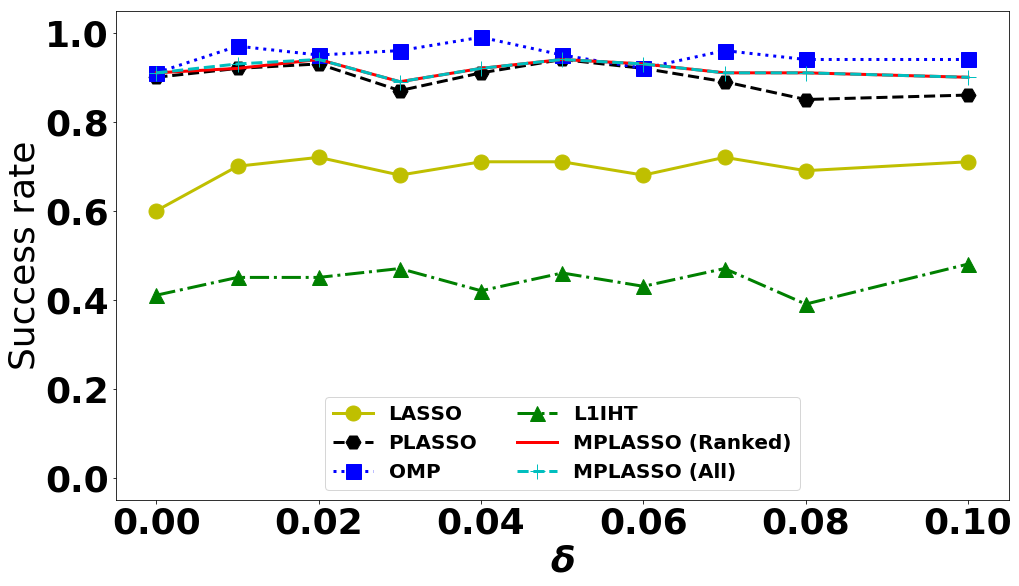

In [129]:
success_vs_xaxis('results_multiple_batches', identifier7, methods + ['mp_lasso', 'mp_lasso'], 
                 'noise_lev_measurements', r'$\delta$', leg_loc = 'lower center',
                 alternative_keys = ['success','success','success','success',
                                    'highest_ranked_is_real', 'tiling_contains_real'],
                 ylabel = 'Success rate',
                 legend_entries = ['LASSO', 'PLASSO', 'OMP', 'L1IHT', 'MPLASSO (Ranked)', 'MPLASSO (All)'],
                 save_as = 'img/' + identifier7 + 'success.png')

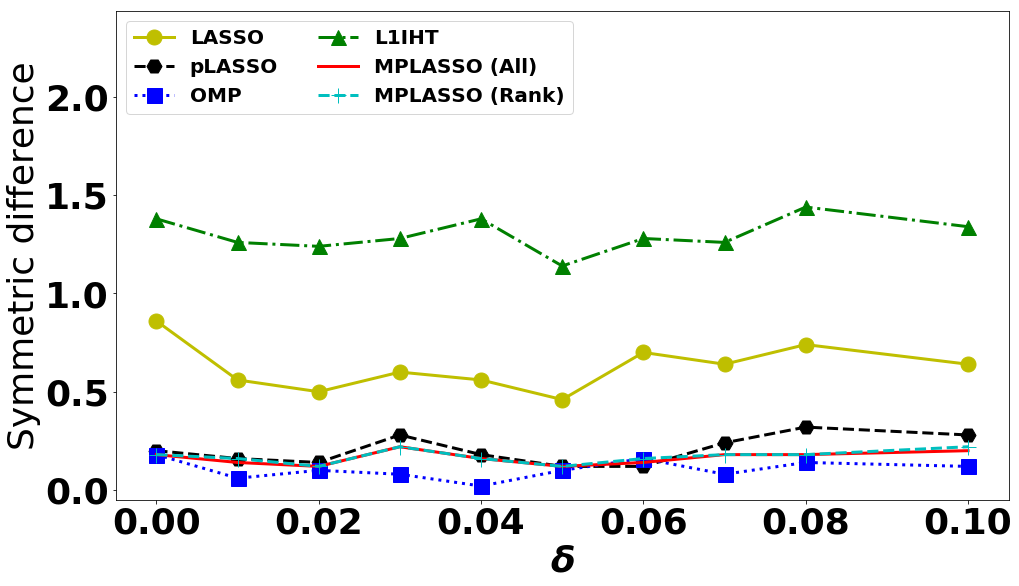

In [91]:
symmdiff_vs_xaxis('results_multiple_batches', identifier7, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
                  r'$\delta$',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left',
                  title = '', save_as = 'img/' + identifier7 + 'symm_diff.png')

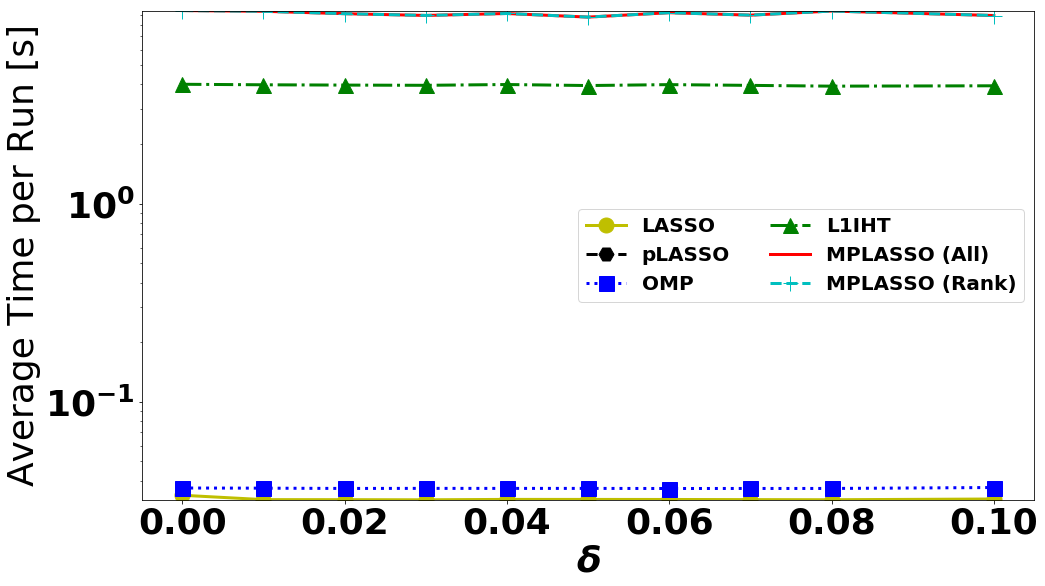

In [92]:
time_vs_xaxis('results_multiple_batches', identifier7, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
              r'$\delta$', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'center right', title = '',
              save_as = 'img/' + identifier7 + 'time.png')

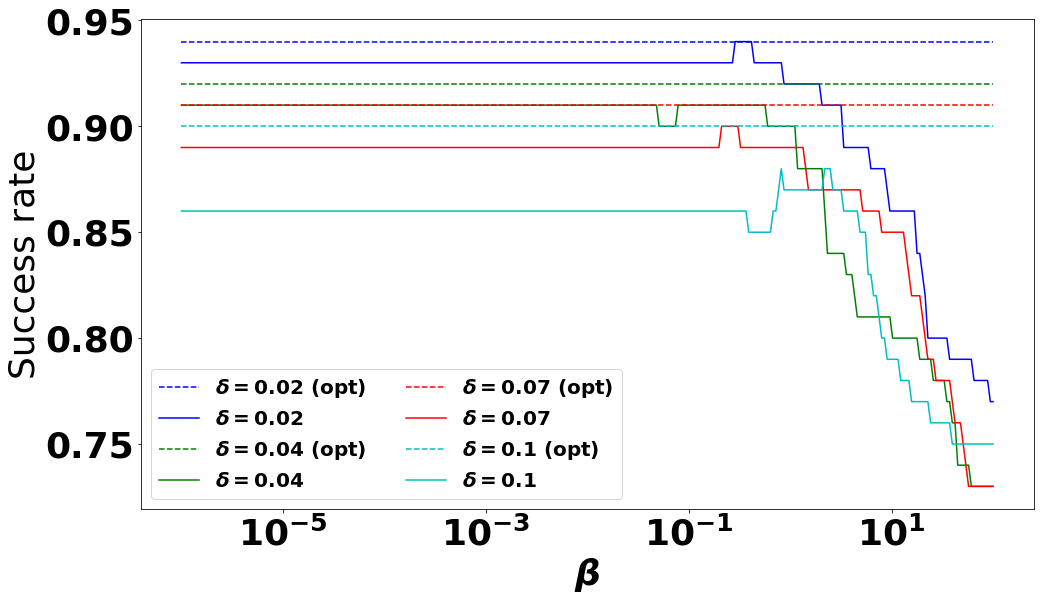

In [93]:
success_vs_beta_disc('results_multiple_batches', identifier7, 'mp_LASSO', 'noise_lev_measurements',  
                     [0.02, 0.04, 0.07, 0.1], ylabel = 'Success rate', title = '', leg_loc = 'lower left', 
                     yaxis_scaling = 'semilog',
                     legend_entries = [r'$\delta = 0.02$ (opt)', r'$\delta = 0.02$',
                                     r'$\delta = 0.04$ (opt)', r'$\delta = 0.04$',
                                     r'$\delta = 0.07$ (opt)', r'$\delta = 0.07$',
                                     r'$\delta = 0.1$ (opt)', r'$\delta = 0.1$'],
                     save_as = 'img/' + identifier7 + 'beta.png')

## 1.2 Gaussian Matrix $600\times 2500$ - Increased signal noise

In [94]:
# Specifying a problem
identifier10 = 'new_gaussian_measurement_noise2_so' # For saving the files to some folder
#random_seeds = np.random.randint(1, 4294967295, size=(16))
random_seeds = [3032585967,  424385364,  650720068,  743041385,  439496303,
       1005762990, 1339741936,  360090062,  853258490, 4247155426]
problem10 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 600, # = m 
    'n_features': 2500, # = n
    'sparsity_level': 15, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.3, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1], # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'gaussian',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier10, '-m', method], problem10)

In [ ]:
%%capture
problem10_mpsr_lasso = dict(problem10)
# Update with multi-penalty framework properties
problem10_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 18}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier10], problem10_mpsr_lasso)

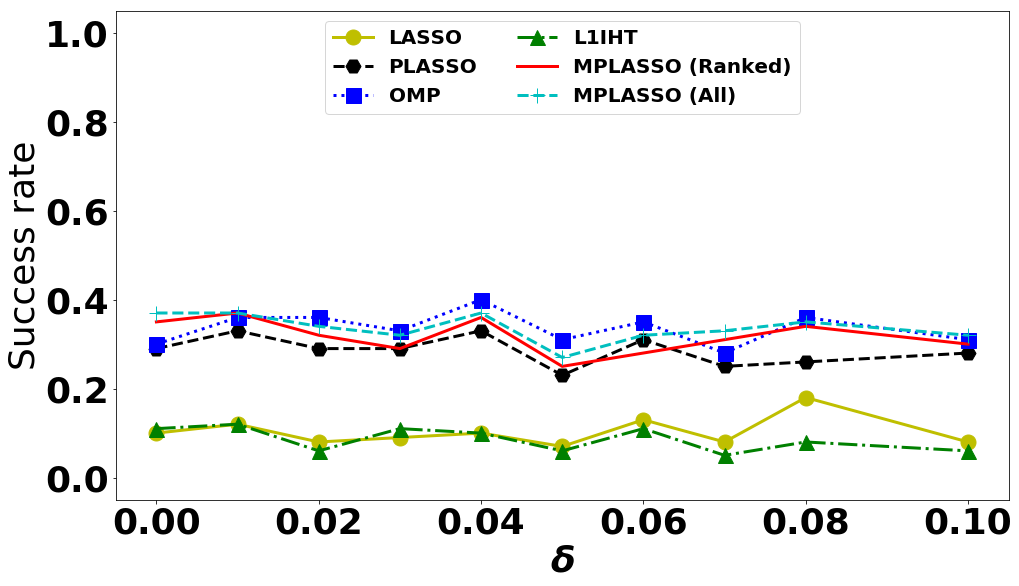

In [128]:
success_vs_xaxis('results_multiple_batches', identifier10, methods + ['mp_lasso', 'mp_lasso'], 
                 'noise_lev_measurements', r'$\delta$', leg_loc = 'upper center',
                 alternative_keys = ['success','success','success','success',
                                    'highest_ranked_is_real', 'tiling_contains_real'],
                 ylabel = 'Success rate',
                 legend_entries = ['LASSO', 'PLASSO', 'OMP', 'L1IHT', 'MPLASSO (Ranked)', 'MPLASSO (All)'],
                 save_as = 'img/' + identifier10 + 'success.png')

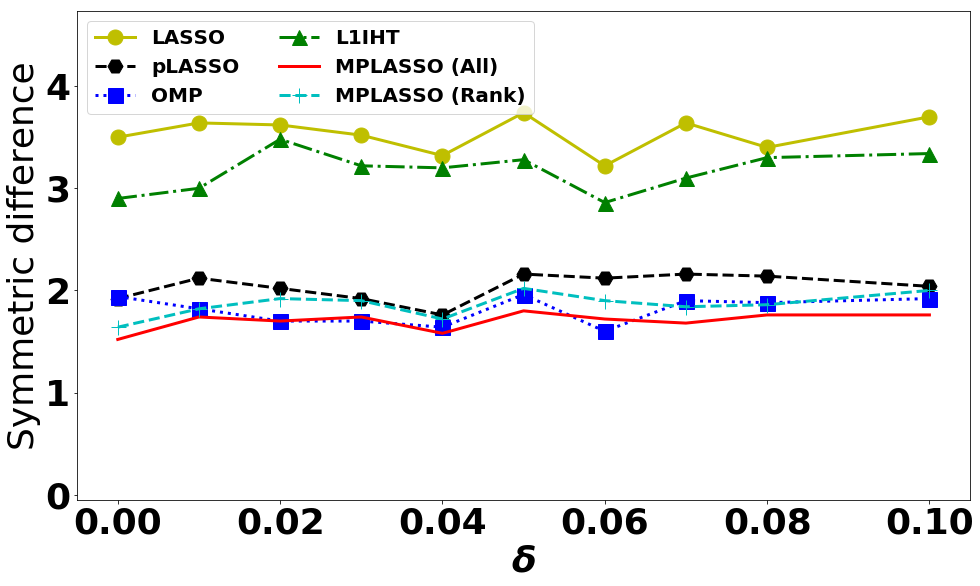

In [96]:
symmdiff_vs_xaxis('results_multiple_batches', identifier_10, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
                  r'$\delta$',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left',
                  title = '', save_as = 'img/' + identifier10 + 'symm_diff.png')

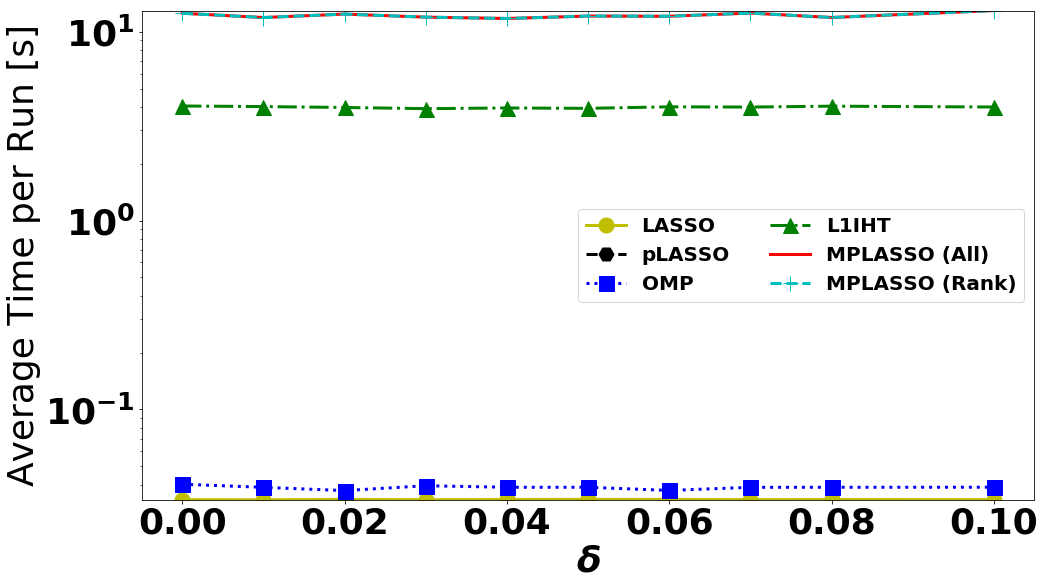

In [97]:
time_vs_xaxis('results_multiple_batches', identifier10, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
              r'$\delta$', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'center right', title = '',
              save_as = 'img/' + identifier10 + 'time.png')

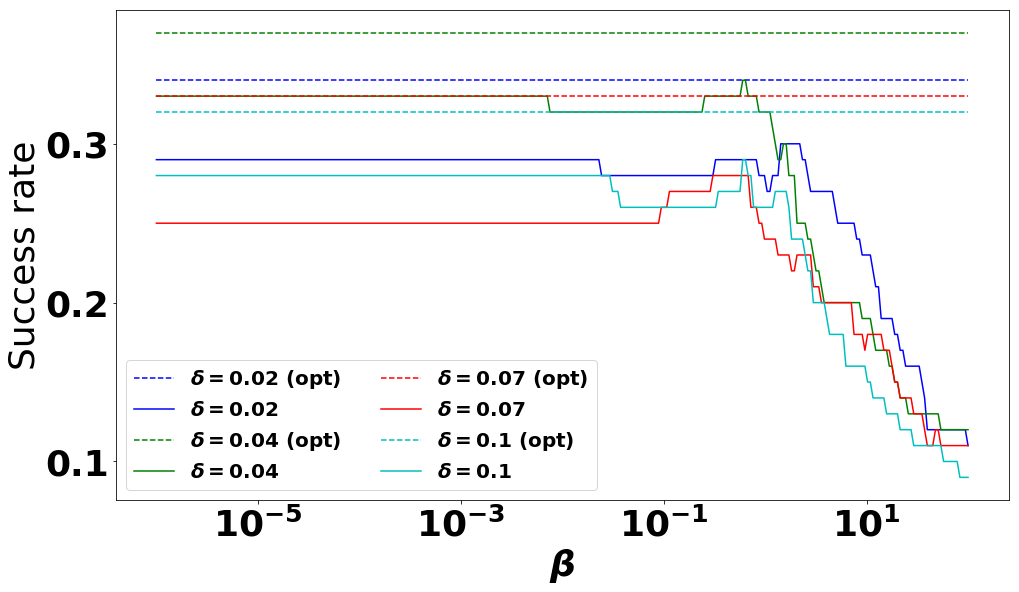

In [98]:
success_vs_beta_disc('results_multiple_batches', identifier10, 'mp_LASSO', 'noise_lev_measurements',  
                     [0.02, 0.04, 0.07, 0.1], ylabel = 'Success rate', title = '', leg_loc = 'lower left', 
                     yaxis_scaling = 'semilog',
                     legend_entries = [r'$\delta = 0.02$ (opt)', r'$\delta = 0.02$',
                                     r'$\delta = 0.04$ (opt)', r'$\delta = 0.04$',
                                     r'$\delta = 0.07$ (opt)', r'$\delta = 0.07$',
                                     r'$\delta = 0.1$ (opt)', r'$\delta = 0.1$'],
                     save_as = 'img/' + identifier10 + 'beta.png')

## 2.1 Case Partial Random Circulant Matrices $900 \times 2500$

In [99]:
# Specifying a problem
identifier8 = 'new_prcm_rademacher_measurement_noise_so' # For saving the files to some folder
#random_seeds = np.random.randint(1, 4294967295, size=(16))
random_seeds = [2612029049, 2954670693,  995236828,  123412909, 1567274549,
       4045568890, 3965140868, 3503412603, 1470178974, 4204092139]
problem8 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 900, # = m 
    'n_features': 2500, # = n
    'sparsity_level': 15, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1], # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'prcm_rademacher',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier8, '-m', method], problem8)

In [ ]:
%%capture
problem8_mpsr_lasso = dict(problem8)
# Update with multi-penalty framework properties
problem8_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 18}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier8], problem8_mpsr_lasso)

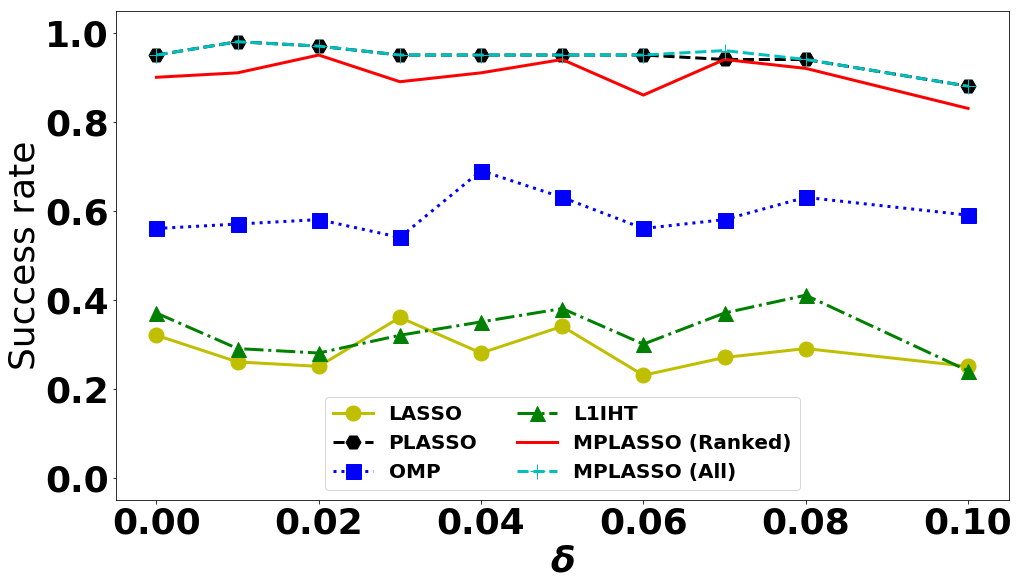

In [127]:
success_vs_xaxis('results_multiple_batches', identifier8, methods + ['mp_lasso', 'mp_lasso'], 
                 'noise_lev_measurements', r'$\delta$', leg_loc = 'lower center',
                 alternative_keys = ['success','success','success','success',
                                    'highest_ranked_is_real', 'tiling_contains_real'],
                 ylabel = 'Success rate',
                 legend_entries = ['LASSO', 'PLASSO', 'OMP', 'L1IHT', 'MPLASSO (Ranked)', 'MPLASSO (All)'],
                 save_as = 'img/' + identifier8 + 'success.png')

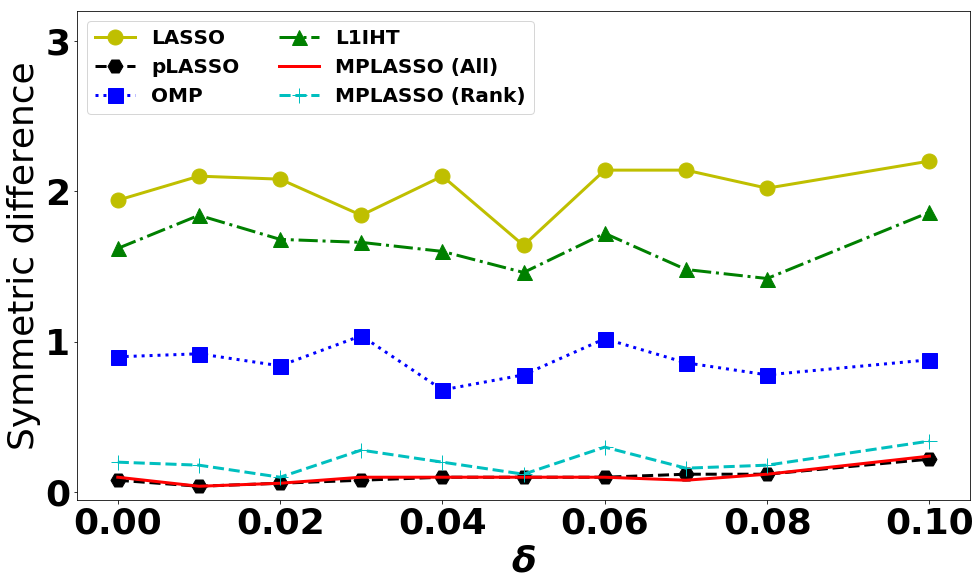

In [101]:
symmdiff_vs_xaxis('results_multiple_batches', identifier8, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
                  r'$\delta$',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left',
                  title = '', save_as = 'img/' + identifier8 + 'symm_diff.png')

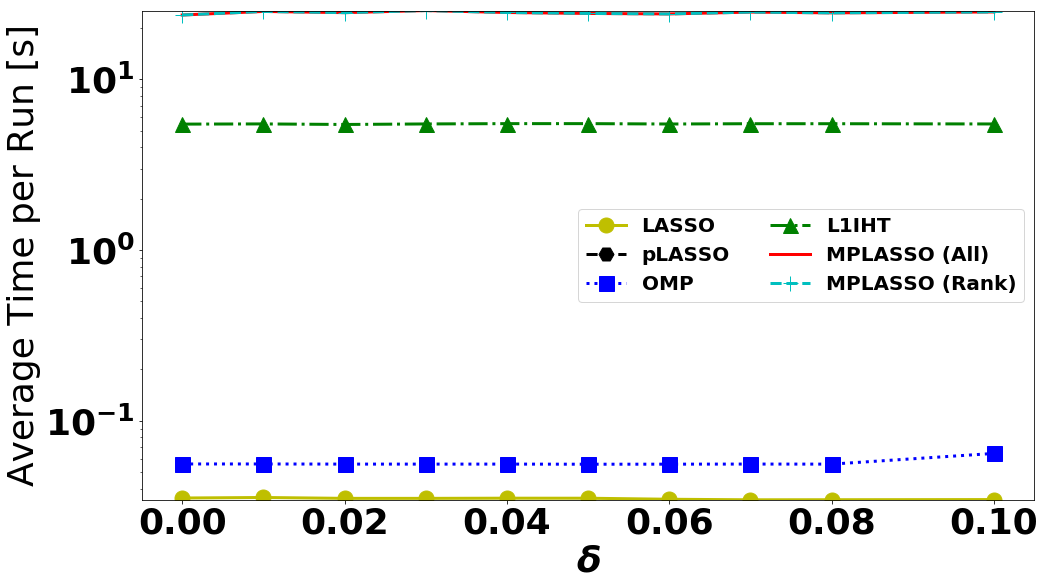

In [102]:
time_vs_xaxis('results_multiple_batches', identifier8, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
              r'$\delta$', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'center right', title = '', save_as = 'img/' + identifier8 + 'time.png')

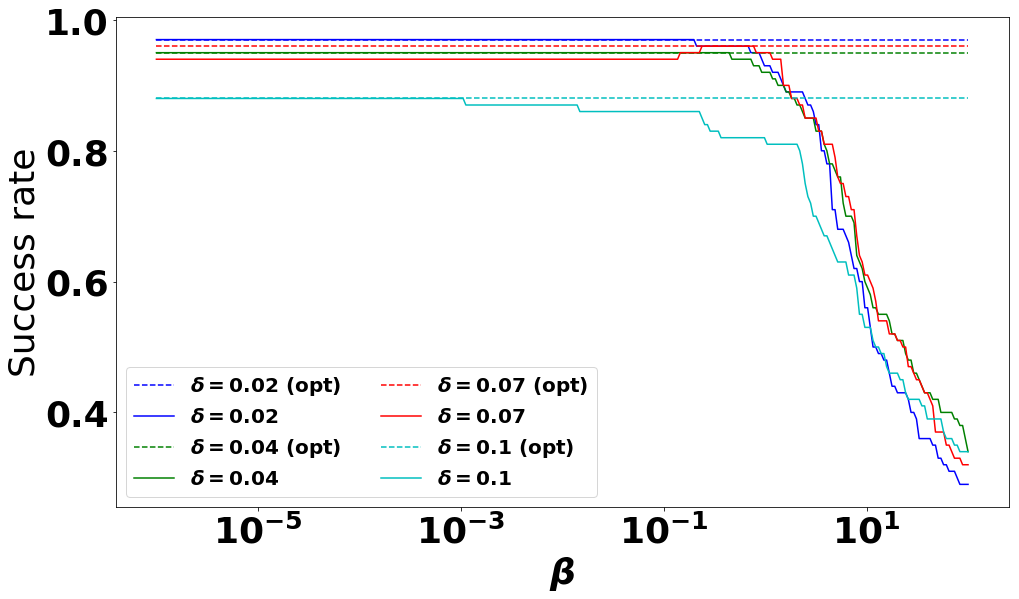

In [103]:
success_vs_beta_disc('results_multiple_batches', identifier8, 'mp_LASSO', 'noise_lev_measurements',  
                     [0.02, 0.04, 0.07, 0.1], ylabel = 'Success rate', title = '', leg_loc = 'lower left', 
                     yaxis_scaling = 'semilog',
                     legend_entries = [r'$\delta = 0.02$ (opt)', r'$\delta = 0.02$',
                                     r'$\delta = 0.04$ (opt)', r'$\delta = 0.04$',
                                     r'$\delta = 0.07$ (opt)', r'$\delta = 0.07$',
                                     r'$\delta = 0.1$ (opt)', r'$\delta = 0.1$'],
                     save_as = 'img/' + identifier8 + 'beta.png')

## 2.2 Partial Random Circulant Matrix $900 \times 2500$ - Increased signal noise

In [105]:
# Specifying a problem
identifier11 = 'new_prcm_rademacher_measurement_noise2_so' # For saving the files to some folder
#random_seeds = np.random.randint(1, 4294967295, size=(16))
random_seeds = [3091255758, 3324157397,  879646226,  704342138, 3689718410,
       3033816920, 3396493238, 4016346505, 3402779293, 1496974869]
problem11 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 600, # = m 
    'n_features': 2500, # = n
    'sparsity_level': 15, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.3, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1], # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : 'gaussian',
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}

In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier11, '-m', method], problem11)

In [ ]:
%%capture
problem11_mpsr_lasso = dict(problem11)
# Update with multi-penalty framework properties
problem11_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 18}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier11], problem11_mpsr_lasso)

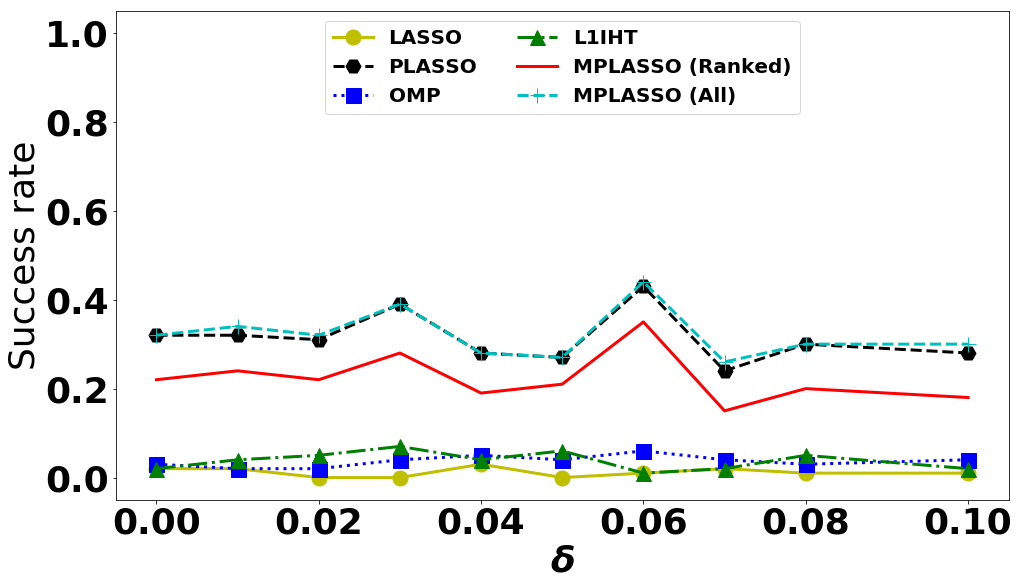

In [124]:
success_vs_xaxis('results_multiple_batches', identifier11, methods + ['mp_lasso', 'mp_lasso'], 
                 'noise_lev_measurements', r'$\delta$', leg_loc = 'upper center',
                 alternative_keys = ['success','success','success','success',
                                    'highest_ranked_is_real', 'tiling_contains_real'],
                 ylabel = 'Success rate',
                 legend_entries = ['LASSO', 'PLASSO', 'OMP', 'L1IHT', 'MPLASSO (Ranked)', 'MPLASSO (All)'],
                 save_as = 'img/' + identifier11 + 'success.png')

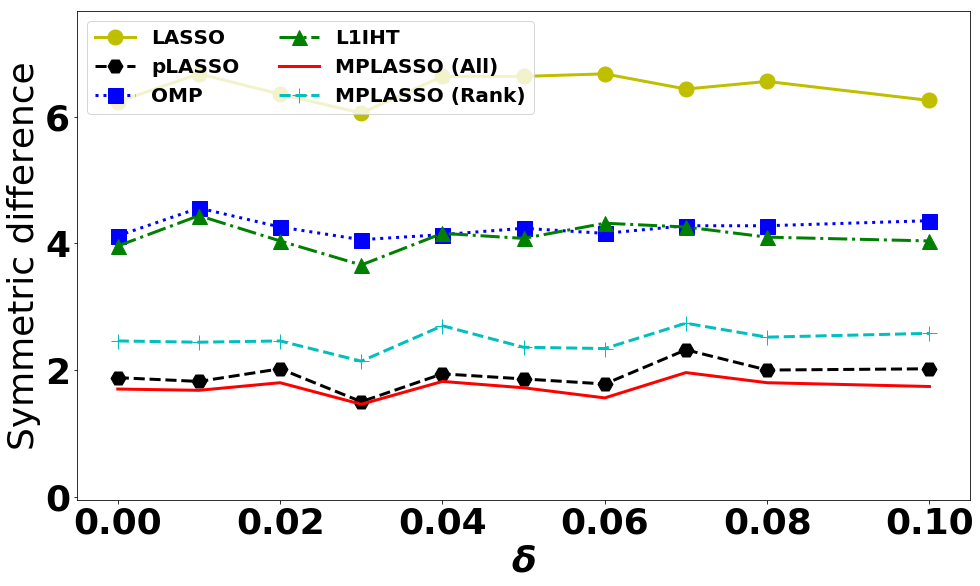

In [108]:
symmdiff_vs_xaxis('results_multiple_batches', identifier11, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
                  r'$\delta$',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left',
                  title = '', save_as = 'img/' + identifier11 + 'symm_diff.png')

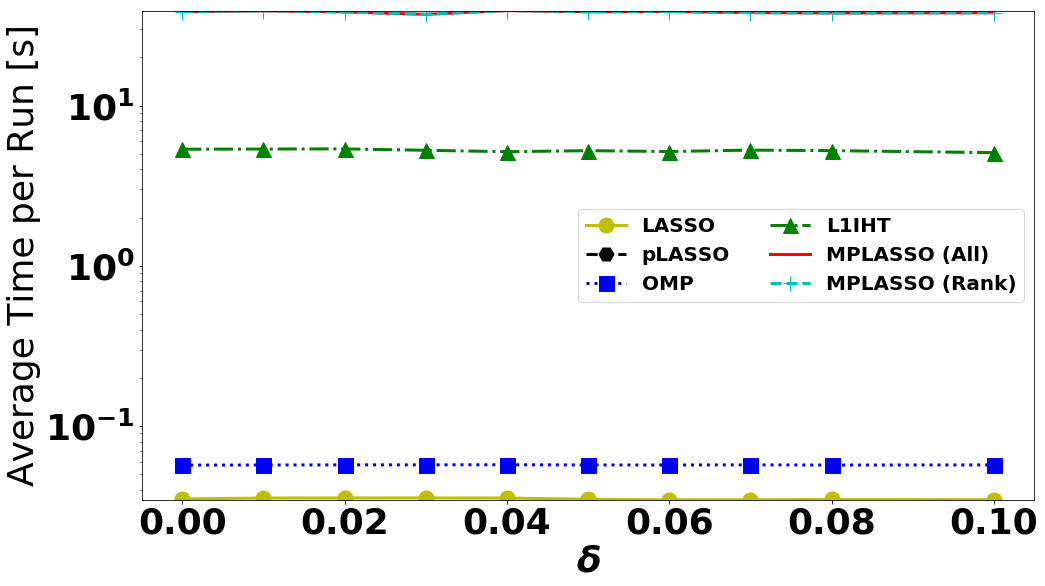

In [109]:
time_vs_xaxis('results_multiple_batches', identifier11, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
              r'$\delta$', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'center right', title = '', save_as = 'img/' + identifier11 + 'time.png')

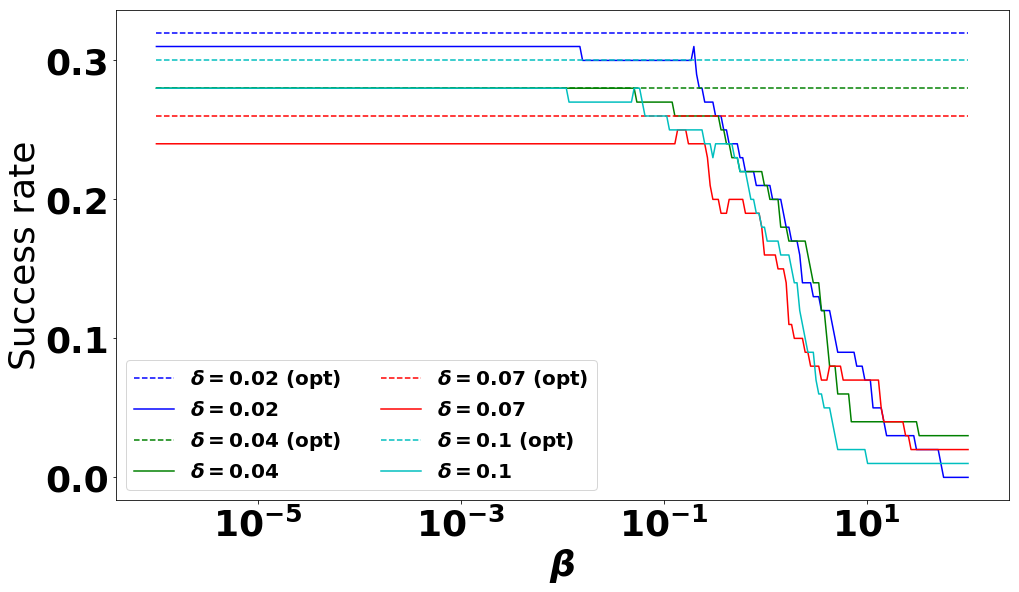

In [110]:
success_vs_beta_disc('results_multiple_batches', identifier11, 'mp_LASSO', 'noise_lev_measurements',  
                     [0.02, 0.04, 0.07, 0.1], ylabel = 'Success rate', title = '', leg_loc = 'lower left', 
                     yaxis_scaling = 'semilog',
                     legend_entries = [r'$\delta = 0.02$ (opt)', r'$\delta = 0.02$',
                                     r'$\delta = 0.04$ (opt)', r'$\delta = 0.04$',
                                     r'$\delta = 0.07$ (opt)', r'$\delta = 0.07$',
                                     r'$\delta = 0.1$ (opt)', r'$\delta = 0.1$'],
                     save_as = 'img/' + identifier11 + 'beta.png')

## 3. Gamma/Gaussian $900 \times 2500$

In [111]:
# Specifying a problem
identifier9 = 'new_gamma_gaussian_measurement_noise_so' # For saving the files to some folder
#random_seeds = np.random.randint(1, 4294967295, size=(16))
random_seeds = [65076590, 1176561621,  196324633, 1137138182,  184124546,
       3568562692, 3783315976, 3508531110, 2095938000, 4108375860]
problem9 = {
    'num_tests': 100, # Repititions per fixed experiment
    'n_measurements': 900, # = m 
    'n_features': 2500, # = n
    'sparsity_level': 15, # Considered support sizes
    'smallest_signal': 1.5, # Lower bound for signal entries. One entry with smallest signal is ensured!
    'largest_signal': 5.0, # Upper bound for signal entries.
    'noise_type_signal': 'uniform', # Uniform sampling of entries of v + maximum will be taken.
    'noise_lev_signal': 0.2, # Bound for absolute of entires of v. 
    'noise_type_measurements': 'scaled_with_measurements', # Does not matter since we have no measurement noise
    'noise_lev_measurements': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1], # No measurement noise
    'random_seed': list(random_seeds),
    'verbosity' : False,
    'sampling_matrix_type' : ('gamma_gaussian', 1.0, 1.0),
    'problem_type' : 'unmixing',
    'sparsity_oracle_in_ranking' : True,
}


In [ ]:
%%capture
for method in methods:
    main_se(['-t', 'run', '-i', identifier9, '-m', method], problem9)

In [ ]:
%%capture
problem9_mpsr_lasso = dict(problem9)
# Update with multi-penalty framework properties
problem9_mpsr_lasso.update({'tiling_options': tiling_options_LASSO, # Options
                'beta_min': 1e-6, # Lower beta bound
                'beta_max': 100.0, # Upper beta bound
                'upper_bound_tilingcreation': 18}) # Sparsity oracle
main_mp(['-t', 'run', '-i', identifier9], problem9_mpsr_lasso)

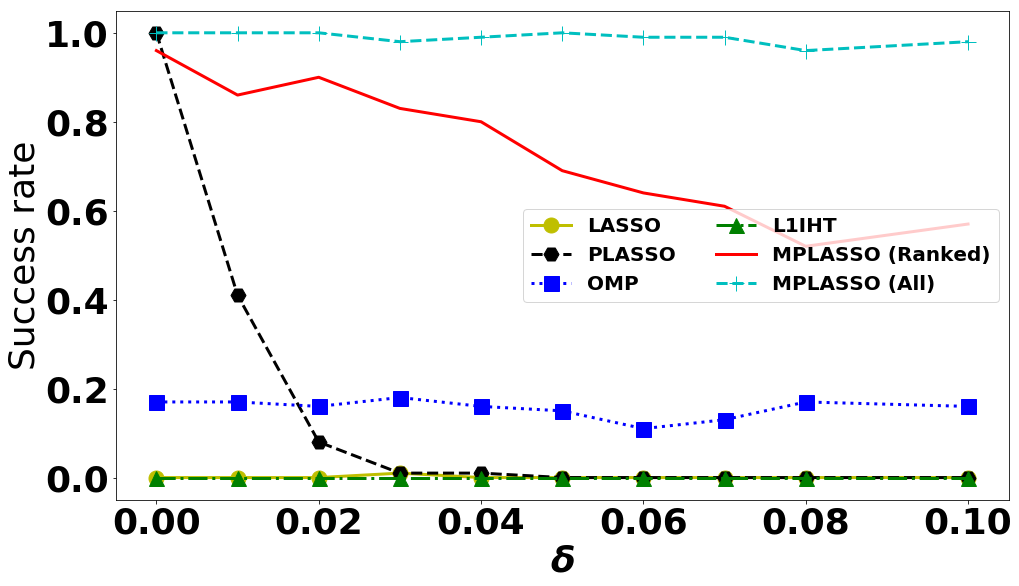

In [121]:
success_vs_xaxis('results_multiple_batches', identifier9, methods + ['mp_lasso', 'mp_lasso'], 
                 'noise_lev_measurements', r'$\delta$', leg_loc = 'center right',
                 alternative_keys = ['success','success','success','success',
                                    'highest_ranked_is_real', 'tiling_contains_real'],
                 ylabel = 'Success rate',
                 legend_entries = ['LASSO', 'PLASSO', 'OMP', 'L1IHT', 'MPLASSO (Ranked)', 'MPLASSO (All)'],
                 save_as = 'img/' + identifier9 + 'success.png')

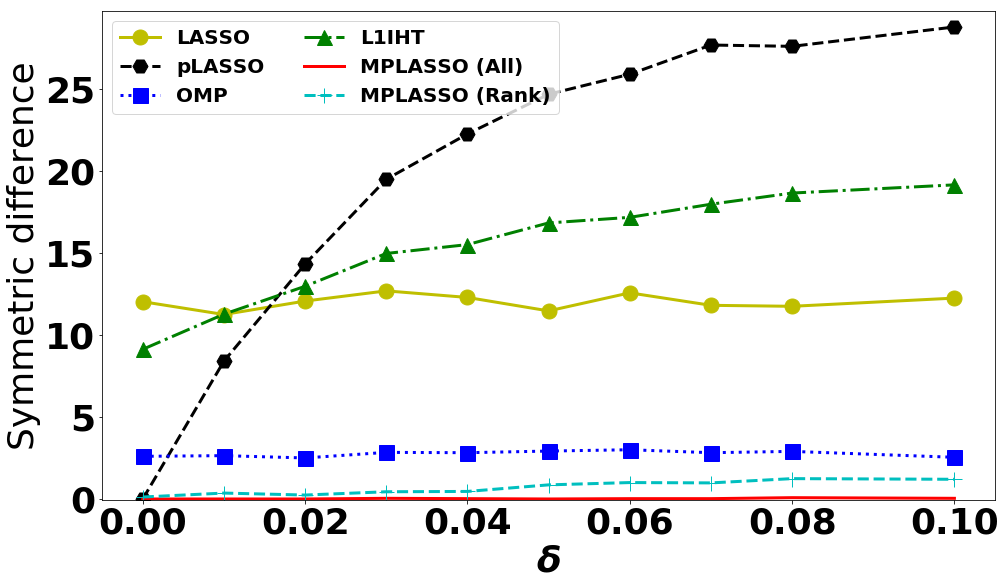

In [113]:
symmdiff_vs_xaxis('results_multiple_batches', identifier9, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
                  r'$\delta$',
                  alternative_keys = ["symmetric_diff_fixed_size", "symmetric_diff_fixed_size", "symmetric_diff_fixed_size", 
                                      "symmetric_diff_fixed_size", "symmetric_difference_best_fixed_size", 
                                      "symmetric_difference"],
                  legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
                  leg_loc = 'upper left',
                  title = '', save_as = 'img/' + identifier9 + 'symm_diff.png')

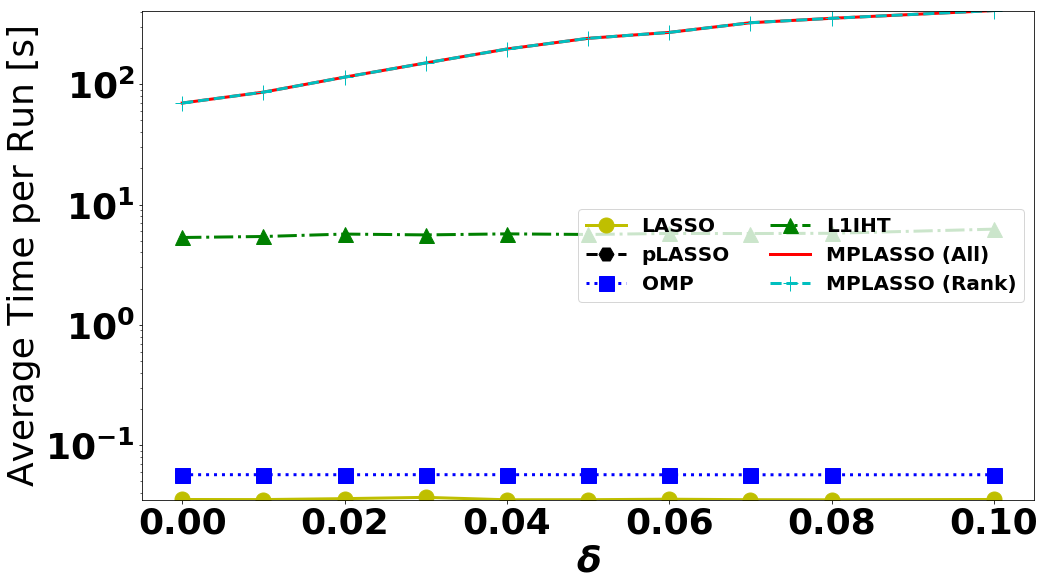

In [114]:
time_vs_xaxis('results_multiple_batches', identifier9, methods + ['mp_LASSO', 'mp_LASSO'], 'noise_lev_measurements',
              r'$\delta$', legend_entries = ['LASSO', 'pLASSO', 'OMP', 'L1IHT', 'MPLASSO (All)', 'MPLASSO (Rank)'],
              leg_loc = 'center right', title = '',
              save_as = 'img/' + identifier9 + 'time.png')

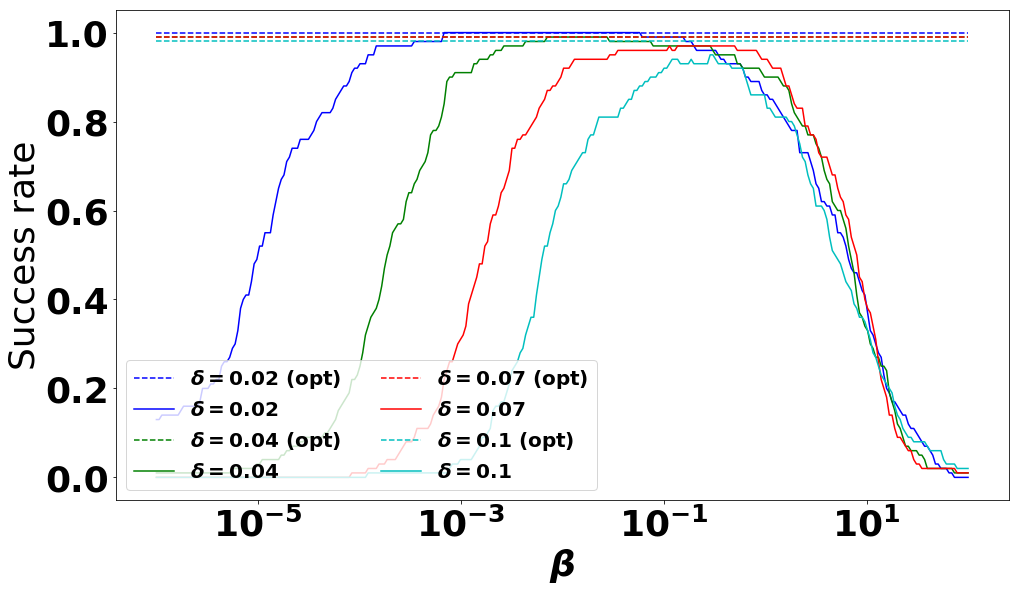

In [115]:
success_vs_beta_disc('results_multiple_batches', identifier_9, 'mp_LASSO', 'noise_lev_measurements',  
                     [0.02, 0.04, 0.07, 0.1], ylabel = 'Success rate', title = '', leg_loc = 'lower left', 
                     yaxis_scaling = 'semilog',
                     legend_entries = [r'$\delta = 0.02$ (opt)', r'$\delta = 0.02$',
                                     r'$\delta = 0.04$ (opt)', r'$\delta = 0.04$',
                                     r'$\delta = 0.07$ (opt)', r'$\delta = 0.07$',
                                     r'$\delta = 0.1$ (opt)', r'$\delta = 0.1$'],
                     save_as = 'img/' + identifier9 + 'beta.png')

### Sources
1. Efron, Bradley, et al. "Least angle regression." The Annals of statistics 32.2 (2004): 407-499.
2. Blumensath, Thomas, and Mike E. Davies. "Iterative hard thresholding for compressed sensing." Applied and computational harmonic analysis 27.3 (2009): 265-274.
3. Jia, Jinzhu, and Karl Rohe. "Preconditioning to comply with the irrepresentable condition." arXiv preprint arXiv:1208.5584 (2012).
4. Tropp, Joel A., and Anna C. Gilbert. "Signal recovery from random measurements via orthogonal matching pursuit." IEEE Transactions on information theory 53.12 (2007): 4655-4666.